# Climate KPIs visualized in Dash App
Collaboration opportunities between cities and businesses for socially equitable climate risk mitigation

![](https://insuranceday.maritimeintelligence.informa.com/-/media/insurance-day/markets/specialty/environmental/climate-change-cooperation.jpg?w=790&hash=AE1254BAD6671AF719770C25B8A08A1C)

In this notebook we have explored the world's largest survey on environmental actions in search for collaboration potential between cities and corporates. By developing a scoring methodology, we aimed to discover climate mitigation concepts that do not perpetuate social inequities. As you read this notebook, you will learn how cities and businesses assess the risks and opportunities posed by climate change. We show how committed the participants in the survey are already working on climate protection, which topics are particularly suitable for collaboration and describe the relationship between climate risks and social equity. Furthermore, we will take a look at the current status and the objectives of the survey participants with regard to their emission values.


# Executive Summary

Using 36 criteria, we developed a **scoring methodology** that allows for a **head-to-head comparison of countries, regions and individual organizations** with respect to their environmental performance. We have visualized our work in an **interactive Dashboard** that you can explore under this link: [interactive dashboard](https://score2-project.herokuapp.com/).


The results from our extensive **Explorative Data Analysis** using both cities and corporates survey responses from 2018 to 2020, indicate that city-business collaboration appears to be most promising in the development of **clean technologies**.

Further, currently city-business collaboration on climate-related topics appears to be most prevalent in North America and Europe while the regions of Latin America and Asia have room for improvement.

# Background information
CDP is an international non-profit organization that supports companies and cities disclose their environmental impact.

Once a year, the CDP voluntarily collects data and information on behalf investors on CO2 emissions, climate risks and reduction targets and strategies of companies using standardized questionnaires. The CDP now manages the world’s largest database of it’s kind.

The dataset provided by CDP contains data for the years 2018, 2019 and 2020. It contains data for the city disclosure (cid) and corporation disclosure (cod) with meta data of their respective cities or corporations. Additionally there are data (cor and cir) containing the answers for cities and corporations for the questionnaires in their respective years. 

It is important to denote that the participation is **voluntary** and that information is **not always verified**. Accordingly, we face a certain sample bias and need to examine the responses with caution. 

# Environment Set-Up

In [1]:
# standard imports
import pandas as pd
import numpy as np

# specific libaries
import glob                                     # read all csv files in the directory
import os                                       # for using OS functions
import warnings                                 # for suppression of depricated messages          
from methods import *                           # selfmade functions and methods
from geopy.geocoders import Nominatim
from tqdm import tqdm
#from sqlalchemy import create_engine           # for SQL access


# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pygal
from matplotlib.gridspec import GridSpec

## Global Variables and Settings

In [2]:
warnings.filterwarnings('ignore')               # for suppression of depricated messages
RSEED = 42                                      # for replicability purposes

# ipython magic commands
%matplotlib inline

# Data-Import/Export and Pickle-Handling
csv_read     = True
pkl_write    = True 
pkl_read     = False
sql_present  = False                            # only True if MySQL-Database is available
db_write     = False                            # only True if MySQL-Database is available
sqlpkl_write = False                             # only True if MySQL-Database is available
cxx_creation = True

# database engine for connection
if sql_present:
    login = pd.read_csv('data/database-login.csv')
    credentials = str(login.iloc[0,5])
    engine = create_engine('mysql+pymysql://'+credentials)

# show plotting params from methods.py
rcParams

{'axes.titlesize': 20,
 'axes.titleweight': 'bold',
 'axes.labelsize': 12,
 'axes.palette': 'mako',
 'lines.linewidth': 3,
 'lines.markersize': 10,
 'xtick.labelsize': 16,
 'ytick.labelsize': 16,
 'patches.labelsize': 12,
 'axes.small_titlesize': 10,
 'axes.small_titleweight': 'bold',
 'axes.small_labelsize': 8,
 'lines.small_linewidth': 3,
 'lines.small_markersize': 8,
 'xtick.small_labelsize': 8,
 'ytick.small_labelsize': 8,
 'patches.small_labelsize': 8}

## Global Functions

In [3]:
def get_responses(data, question_num, column_number=[1], row_number=[1], theme='combined',year=['2018','2019','2020']):
    '''’A query function that creates a new dataframe with responses from the given data.'''
    # Reduktion auf ausgewählte Menge:
    responses = data[(data.theme == theme) &
                     (data.year.isin(year)) &
                     # Abfrageteil bei Nutzung der 'question_number':                   
                     (data.question_number == question_num) &
                     # Abfrageteil bei Nutzung der 'q_nr':
                     #(data.q_nr == question_num) &
                     (data.column_number.isin(column_number)) &
                     (data.row_number.isin(row_number)) 
                    ].copy()

    # Ausgabe der Haupt-Frage:
    print(f'AnswerCount = {responses.shape[0]}')

    # Variablenbesetzung bei Nutzung der 'question_number':
    quest_num = data[(data.question_number == question_num) & (data.year == year[0])].question_number.iat[0]
    question  = data[(data.question_number == question_num) & (data.year == year[0])].question_name.iat[0]

    print(f'QuestionNumber = {quest_num}:\n{question}')

    # Sortierung:
    result = responses.sort_values(by=['type',
                                       'theme',
                                       #'year',
                                       'account_number',
                                       'response_pnt'])[[#'type',
                                                         #'theme',
                                                         #'year',
                                                         'account_number',
                                                         'entity',
                                                         'response_pnt',
                                                         'column_name',
                                                         'row_name',
                                                         'response_answer']]
    return result

#answer_df = get_responses(cir, '1.0a', [0,1,2,3,4], [i for i in range(2146)], theme='combined', year=['2020'])
#answer_df

def identify_theme(strng):
    if strng[0] == 'C':
        result = 'climate'
    elif strng[0] == 'W':
        result = 'water'
    else:
        result = 'other'
    return result

# Data Loading & Mining

In [4]:
# Cities Disclosing (combining the years 2018, 2019 and 2020)
path = 'data/Cities/Disclosing/'
filename_start = '20'
if csv_read:  cid_raw = get_data(path, filename_start)
if db_write:  write_to_db(cid_raw,'cid_raw')
if pkl_write: cid_raw.to_pickle(path+'cid_raw.pkl')
if pkl_read:  cid_raw = pd.read_pickle(path+'cid_raw.pkl')

['2018_Cities_Disclosing_to_CDP.csv', '2019_Cities_Disclosing_to_CDP.csv', '2020_Cities_Disclosing_to_CDP.csv']

A dataframe with 2068 rows and 13 columns has been created!
Column names are now lower case and spaces are replaced by "_".


In [5]:
# Cities Responses (combining the years 2018, 2019 and 2020)
path = 'data/Cities/Responses/'
filename_start = '20'
if csv_read:  cir_raw = get_data(path, filename_start)
if db_write:  write_to_db(cir_raw,'cir_raw')
if pkl_write: cir_raw.to_pickle(path+'cir_raw.pkl')
if pkl_read:  cir_raw = pd.read_pickle(path+'cir_raw.pkl')

['2018_Full_Cities_Dataset.csv', '2019_Full_Cities_Dataset.csv', '2020_Full_Cities_Dataset.csv']

A dataframe with 1542496 rows and 18 columns has been created!
Column names are now lower case and spaces are replaced by "_".


In [6]:
# Corporations Disclosing  (combining Climate_Change and Water_Security with the years 2018, 2019 and 2020)
path = 'data/Corporations/Disclosing/'
filename_start = '20'
if csv_read:  cod_raw = get_data(path, filename_start)
if db_write:  write_to_db(cod_raw,'cod_raw')
if pkl_write: cod_raw.to_pickle(path+'cod_raw.pkl')
if pkl_read:  cod_raw = pd.read_pickle(path+'cod_raw.pkl')

['2018_Corporates_Disclosing_to_CDP_Climate_Change.csv', '2018_Corporates_Disclosing_to_CDP_Water_Security.csv', '2019_Corporates_Disclosing_to_CDP_Climate_Change.csv', '2019_Corporates_Disclosing_to_CDP_Water_Security.csv', '2020_Corporates_Disclosing_to_CDP_Climate_Change.csv', '2020_Corporates_Disclosing_to_CDP_Water_Security.csv']

A dataframe with 3370 rows and 23 columns has been created!
Column names are now lower case and spaces are replaced by "_".


In [7]:
# Corporations Responses  (combining Climate_Change and Water_Security with the years 2018, 2019 and 2020)
path = 'data/Corporations/Responses/'
filename_start = '20'
if csv_read:  cor_raw = get_data(path, filename_start)
if db_write:  write_to_db(cor_raw,'cor_raw')
if pkl_write: cor_raw.to_pickle(path+'cor_raw.pkl')
if pkl_read:  cor_raw = pd.read_pickle(path+'cor_raw.pkl')

['2018_Full_Climate_Change_Dataset.csv', '2018_Full_Water_Security_Dataset.csv', '2019_Full_Climate_Change_Dataset.csv', '2019_Full_Water_Security_Dataset.csv', '2020_Full_Climate_Change_Dataset.csv', '2020_Full_Water_Security_Dataset.csv']

A dataframe with 2422792 rows and 20 columns has been created!
Column names are now lower case and spaces are replaced by "_".


## Importing Missing City Names and Geo Locations from External Sources (.xls)

To obtain the best possible overview of the city disclosure data set, we import the **missing city names** as well as the **population** for the corresponding organizations. This will allows us to get a slightly better understanding of the underlying data and helps later on to conduct more accurate analysis. 

In order to append the missing city names, as well as the missing popualtion data we used public available sources. Additionally we checked all cities with a population of 3000 or less and a population of 100000 or more and corrected the data where necessary.

In [8]:
#importing additional population data and city names, that were missing
cid_ext01 = pd.read_excel('data/Cities/cities_final.xls')

#merging imported data
cid_pop = pd.merge(left=cid_raw,
                   right=cid_ext01[['City', 'Population']],
                   left_on=cid_raw['account_number'],
                   right_on=cid_ext01['AccountNumber'],
                   how='left')

#drop the key_0 column which is generated during the merge step
cid_pop.drop('key_0', axis=1, inplace=True)

Now that we have all `City`and `Population`data, it is worthwhile to import the corresponding geo locations to obtain a better geographical understanding of the dataset. For that, we use the `GeoPy`library and pull latitude and longitude data from the city names. 
To reduce run-time of this notebook, we load the data from a separate file. 

In [9]:
# import the coordinates for each of the cities
cid_ext02 = pd.read_excel('data/Cities/city_coordinates_data.xls')

# drop duplicates rows based on account_number
cid_ext02 = cid_ext02.drop_duplicates(subset="account_number", keep="first")

In [10]:
#merge location data to cleaned city disclosure dataframe
cid_loc = pd.merge(left=cid_raw,
                   right=cid_ext02[['account_number','lat', 'lon']],
                   on="account_number",
                   how='left')

# Data Cleaning
The original goal of this step was to create a basis on which answers to specific questions could be directly accessed and evaluated.

During the intensive examination of the data provided by CDP (especially the extensive response data sets), we came across various issues that made structurally clean or fully automated access difficult or impossible:

- Question numbers and contents differ from year to year
- Content of the question cannot be systematically determined
- Reply sequence partly individually selectable
- Numerical, categorical and free text mixed in one column
- Many false statements, transmission errors (always only detectable in relation to the individual question)
- Responses in different languages

After various attempts to fully address the problems with the help of functions, we decided to leave the data as it is and to carry out the selective data cleaning always in the context of dealing with a specific question.
So here we have (apart from the obvious deletion of lines without a meaningful answer) only made a structural unification in order to create a basis for functions that allow an approach to a single question.

## Cities Disclosure (cid)

We simplify the dataframe by dropping all less important columns

In [11]:
# Creating a new DataFrame for working (incl. creating some new colums/features):
if cxx_creation:
    cid = pd.DataFrame()
    cid['type']                     = ['cid' for i in cid_raw.index]
    cid['theme']                    = 'combined'
    #cid['year']                    = cid_raw['year_reported_to_cdp']
    cid['year']                     = [str(i) for i in cid_raw.year_reported_to_cdp]
    cid['account_number']           = cid_raw['account_number']
    cid['public']                   = cid_raw['access']
    cid['entity']                   = cid_pop['City']
    cid['country']                  = cid_raw['country']
    cid['region']                   = cid_raw['cdp_region']
    cid['population']               = cid_pop['Population']
    cid['city']                     = cid_pop['City']
    cid['lat']                      = cid_loc['lat']
    cid['lon']                      = cid_loc['lon']

    # Due to redundant or missing information the following columns are no longer needed:
    #cid['organization']            = cid_raw['organization']
    #cid['reporting_authority']     = cid_raw['reporting_authority']
    #cid['first_time_discloser']    = cid_raw['first_time_discloser']
    #cid['population_year']         = cid_raw['population_year']
    #cid['last_update']             = cid_raw['last_update']
    #cid['altitude']                = cid_raw['altitude']

cid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2068 entries, 0 to 2067
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            2068 non-null   object 
 1   theme           2068 non-null   object 
 2   year            2068 non-null   object 
 3   account_number  2068 non-null   int64  
 4   public          2068 non-null   object 
 5   entity          2068 non-null   object 
 6   country         2068 non-null   object 
 7   region          2068 non-null   object 
 8   population      2068 non-null   int64  
 9   city            2068 non-null   object 
 10  lat             2045 non-null   float64
 11  lon             2045 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 194.0+ KB


## Cities Responses (cir)

Next, we again simplify the dataframe for the cities responses by omitting all columns that we perceive as less relevant for the further analysis. 

In [12]:
# transfer city, latitude, longitude and population data to city response dataframe
if cxx_creation:
    loc_info = cid[["account_number", "city", "lat", "lon", "population"]]

# drop duplicates rows based on account_number
if cxx_creation:
    loc_info=loc_info.drop_duplicates(subset="account_number", keep="first")

# Add city, lat, lon and population to raw dataset.
if cxx_creation:
    cir_loc = pd.merge(left=cir_raw,
                       right=loc_info, 
                       on="account_number",
                       how="left")

In [13]:
# Creating a new DataFrame for working (incl. creating some new colums/features):
if cxx_creation:
    cir = pd.DataFrame()
    cir['type']                   = ['cir' for i in cir_raw.index]
    cir['theme']                  = 'combined'
    cir['year']                   = cir_raw.apply(lambda x : str(x['questionnaire'][-4:]), axis=1)
    cir['account_number']         = cir_raw['account_number']
    cir['entity']                 = cir_loc['city']
    cir['city']                   = cir_loc['city']
    cir['population']             = cir_loc['population'] 
    cir['country']                = cir_raw['country']
    cir['region']                 = cir_raw['cdp_region']
    cir['section']                = cir_raw['section']
    cir['question_number']        = cir_raw['question_number']
    cir['question_name']          = cir_raw['question_name']
    cir['column_number']          = cir_raw['column_number']
    cir['column_name']            = cir_raw['column_name']
    cir['row_number']             = cir_raw['row_number']
    cir['row_name']               = cir_raw['row_name']
    cir['response_answer']        = cir_raw['response_answer']
    cir['lat']                    = cir_loc['lat']
    cir['lon']                    = cir_loc['lon']

    # Due to redundant or missing information the following columns are no longer needed:
    #cir['questionnaire']         = cir_raw['questionnaire']
    #cir['year_reported_to_cdp']  = cir_raw['year_reported_to_cdp']
    #cir['cdp_region']            = cir_raw['cdp_region']
    #cir['parent_section']        = cir_raw['parent_section']
    #cir['comments']              = cir_raw['comments']
    #cir['file_name']             = cir_raw['file_name']
    #cir['last_update']           = cir_raw['last_update']
    
if cxx_creation:
    cir.info()
    
# Deleting cir[response_answer'] = NaN:
if cxx_creation:
    print(f'Number of rows before deleting: {cir.shape[0]}')
    cir.dropna(axis=0, subset=['response_answer'], inplace=True)
    print(f'Number of rows after deleting NaNs:  {cir.shape[0]}')
    
# 'Question not applicable' represents about 33% of the answers. 
# Deleting cir[response_answer'] = 'Question not applicable':
if cxx_creation:
    print(f'Number of rows before deleting: {cir.shape[0]}')
    cir = cir.loc[cir['response_answer'] != 'Question not applicable']
    print(f'Number of rows after deleting response_answers with"Question not applicable":   {cir.shape[0]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542496 entries, 0 to 1542495
Data columns (total 19 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   type             1542496 non-null  object 
 1   theme            1542496 non-null  object 
 2   year             1542496 non-null  object 
 3   account_number   1542496 non-null  int64  
 4   entity           1542496 non-null  object 
 5   city             1542496 non-null  object 
 6   population       1542496 non-null  int64  
 7   country          1542496 non-null  object 
 8   region           1542496 non-null  object 
 9   section          1542496 non-null  object 
 10  question_number  1542496 non-null  object 
 11  question_name    1542496 non-null  object 
 12  column_number    1542496 non-null  int64  
 13  column_name      1468405 non-null  object 
 14  row_number       1542496 non-null  int64  
 15  row_name         617270 non-null   object 
 16  response_answer  1

## 5.3 Corporations Disclosing (cod)

In [14]:
# Creating a new DataFrame for working (incl. creating some new colums/features):
if cxx_creation:
    cod = pd.DataFrame()
    cod['type']                         = ['cod' for i in cod_raw.index]
    cod['theme']                        = cod_raw.apply(lambda x : x['questionnaire'].split(' ')[0].lower(), axis=1)
    cod['year']                         = cod_raw.apply(lambda x : str(x['questionnaire'].split(' ')[-1]), axis=1)
    cod['account_number']               = cod_raw['account_number']
    cod['public']                       = cod_raw['public']
    cod['entity']                       = cod_raw['organization']
    cod['country']                      = cod_raw['country']
    cod['addressed_by']                 = cod_raw['samples']
    cod['minimum_tier']                 = cod_raw['minimum_tier']
    cod['selected_tier']                = cod_raw['selected_tier']
    cod['authority_types']              = cod_raw['authority_types']              
    cod['activities']                   = cod_raw['activities']                   
    cod['sectors']                      = cod_raw['sectors']                      
    cod['industries']                   = cod_raw['industries']                   
    cod['primary_activity']             = cod_raw['primary_activity']             
    cod['primary_sector']               = cod_raw['primary_sector']               
    cod['primary_industry']             = cod_raw['primary_industry']             
    cod['primary_questionnaire_sector'] = cod_raw['primary_questionnaire_sector'] 
    
    # Due to redundant or missing information the following columns are no longer needed:
    #cod['survey_year']                 = cod_raw['survey_year']
    #cod['region']                      = cod_raw['region']
    #cod['invitation_status']           = cod_raw['invitation_status']
    #cod['response_received_date']      = cod_raw['response_received_date']
    #cod['questionnaire']               = cod_raw['questionnaire']
    #cod['theme']                       = cod_raw['theme']
    #cod['primary_ticker']              = cod_raw['primary_ticker']
    #cod['tickers']                     = cod_raw['tickers']
    
cod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   type                          3370 non-null   object
 1   theme                         3370 non-null   object
 2   year                          3370 non-null   object
 3   account_number                3370 non-null   int64 
 4   public                        3370 non-null   object
 5   entity                        3370 non-null   object
 6   country                       3370 non-null   object
 7   addressed_by                  2136 non-null   object
 8   minimum_tier                  2929 non-null   object
 9   selected_tier                 3370 non-null   object
 10  authority_types               3370 non-null   object
 11  activities                    3370 non-null   object
 12  sectors                       3370 non-null   object
 13  industries        

## 5.4 Corporations Responses (cor)

In [15]:
# Creating a new DataFrame for working (incl. creating some new colums/features):
if cxx_creation:
    cor = pd.DataFrame()
    cor['type']                     = ['cor' for i in cor_raw.index]
    cor['theme']                    = cor_raw.apply(lambda x : identify_theme(x['question_number']), axis=1)
    cor['year']                     = [str(i) for i in cor_raw.survey_year]
    cor['account_number']           = cor_raw['account_number']
    cor['entity']                   = cor_raw['organization']
    cor['section']                  = cor_raw['module_name']
    cor['question_number']          = cor_raw['question_number']
    cor['question_name']            = cor_raw['question_unique_reference']
    cor['column_number']            = cor_raw['column_number']
    cor['column_name']              = cor_raw['table_columns_unique_reference']
    cor['row_number']               = cor_raw['row_number']
    cor['row_name']                 = cor_raw['row_name']
    cor['response_answer']          = cor_raw['response_value']

    # Due to redundant or missing information the following columns are no longer needed:
    #cor['response_received_date']  = cor_raw['response_received_date']
    #cor['accounting_period_to']    = cor_raw['accounting_period_to']
    #cor['ors_response_id']         = cor_raw['ors_response_id']
    #cor['submission_date']         = cor_raw['submission_date']
    #cor['page_name']               = cor_raw['page_name']
    #cor['column_name']             = cor_raw['column_name']
    #cor['data_point_name']         = cor_raw['data_point_name']
    #cor['data_point_id']           = cor_raw['data_point_id']
    #cor['comments']                = cor_raw['comments']
    
# Replacing cor[response_answer'] = NaN with 0:
if cxx_creation:
    cor['column_number'].fillna(0, inplace=True)

    # Changing the dtype to int64:
    cor['column_number'] = cor['column_number'].astype('int64')
    
if cxx_creation:
    cor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422792 entries, 0 to 2422791
Data columns (total 13 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   type             object
 1   theme            object
 2   year             object
 3   account_number   int64 
 4   entity           object
 5   section          object
 6   question_number  object
 7   question_name    object
 8   column_number    int64 
 9   column_name      object
 10  row_number       int64 
 11  row_name         object
 12  response_answer  object
dtypes: int64(3), object(10)
memory usage: 240.3+ MB


# Initial Data Exploration

With respect to the tasks and conditions of the [CDP Kaggle Competition](https://www.kaggle.com/c/cdp-unlocking-climate-solutions), we  defined our main goals for EDA and feature engineering as follows:

1. help cities and corporates to optimize and communicate there mitigation and climate protection strategies
2. show intersection between the interests of the public sekctor and private companies to strengthen collaborations and to encourage to start new ones.
3. identify and visualize best practices that strike the best possible blance climate protection and aspects of social justice
4. generate new features and explain the insights gained from them
5. create relevant KPI
6. interpretation of unstructured free text responses
7. usage of cluster algorithms to get additional insights

As part of our EDA we dig deep into the data sets and examine them for findings. In doing so, we particularly address goals 1, 2 and 3. Based on our qualitative analysis, we then develop a scoring system that includes the following dimensions:
<br/>
![score2](figures/Scoring_model.png)
<br/>
After an introductory presentation of the basic survey data, the structure of the following section is aligned with the six elements of our SCORE2 model.




## Who are the participating cities?

From the visualization, we can derive that a major share of participating cities originate from **North and **South America**. The Asian region in contrast is less represented. This is an important observation since the participating corporates are based in North America. Therefore, also having a large share of city respondents from this area facilitates comparisons between cities and corporates later on. 


In [16]:
# visualize disclosure data using lat and lon data 
fig = px.scatter_geo(cid, 
                     lat="lat",
                     lon="lon",
                     color="region",
                     color_discrete_sequence=px.colors.sequential.Plasma,
                     hover_name="country",
                     size="population",
                     animation_frame="year", # consider replacing thsi with organization count per country
                     projection="eckert4",
                     size_max=30)
fig.show()

## 5.4 Corporations Responses


To obtain a fundamental understanding of the underlying city response survey data, we start by visualizing the number of responses per module name and how the number of responses has changed in each module over time. To avoid imbalances, we take into account that each module has a different number different number of questions which in turn differ in their amount of columns and even rows. 

We use this graphical representation to illustrate where we organization and companies provide most information and can therefore our further analysis on these seemingly more important areas. 

OSError: no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7e

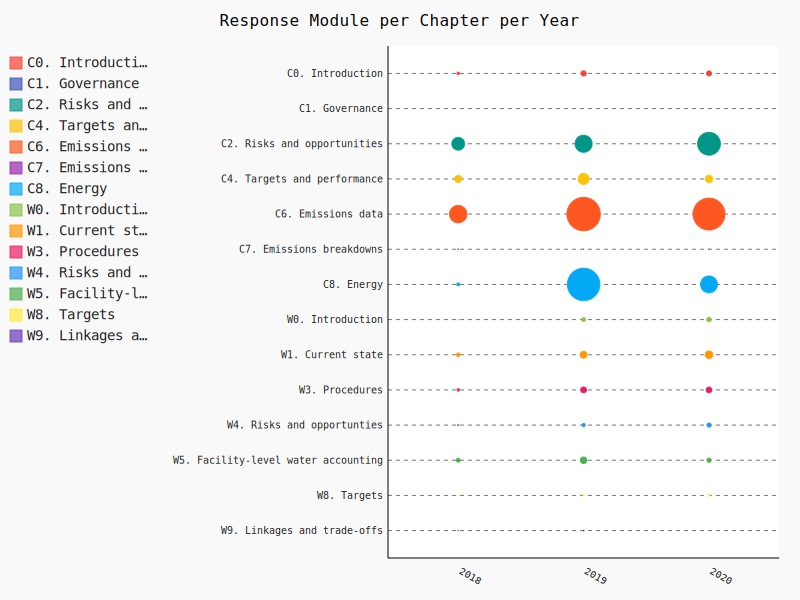

In [17]:
# response number per module per question number and column number 2018

a_2018 = cor[cor["year"]=='2018'].groupby(by="section")["question_number"].size()
b_2018 = cor[cor["year"]=='2018'].groupby(by="section")["question_number"].nunique()
c_2018 = cor[cor["year"]=='2018'].groupby(by="section")["column_number"].apply(lambda x: x.nunique())
d_2018 = cor[cor["year"]=='2018'].groupby(by="section")["row_number"].apply(lambda x: x.nunique())

res_2018 = a_2018/(b_2018+c_2018+d_2018)

# responses per module per question number and column number 2019
a_2019 = cor[cor["year"]=='2019'].groupby(by="section")["question_number"].size()
b_2019 = cor[cor["year"]=='2019'].groupby(by="section")["question_number"].nunique()
c_2019 = cor[cor["year"]=='2019'].groupby(by="section")["column_number"].apply(lambda x: x.nunique())
d_2019 = cor[cor["year"]=='2019'].groupby(by="section")["row_number"].apply(lambda x: x.nunique())


res_2019 = a_2019/(b_2019+c_2019+d_2019)

# responses per module per question number and column number 2020
a_2020 = cor[cor["year"]=='2020'].groupby(by="section")["question_number"].size()
b_2020 = cor[cor["year"]=='2020'].groupby(by="section")["question_number"].nunique()
c_2020 = cor[cor["year"]=='2020'].groupby(by="section")["column_number"].apply(lambda x: x.nunique())
d_2020 = cor[cor["year"]=='2020'].groupby(by="section")["row_number"].apply(lambda x: x.nunique())


res_2020 = a_2020/(b_2020+c_2020+d_2020)

# get list of module names
modules = sorted(cor["section"].unique())

# get list of years
year = sorted(cor["year"].unique())

# merge response counts into one dataframe
d = pd.concat([res_2018,res_2019,res_2020], axis=1).T
d

df_dot = pd.DataFrame(data=d, columns=modules)
df_dot["Year"] = year
df_dot.set_index("Year", inplace=True)

# append data in list 
a = []
b = []
c = []
d = []
e = []
f = []
g = []
h = []
i = []
j = []
k = []
l = []
m = []
n = [] 
# creating dot chart object
dot_chart = pygal.Dot(x_label_rotation=30)
# naming the titile
dot_chart.title = 'Response Module per Chapter per Year'
dot_chart.x_labels = [2018, 2019, 2020]
for index,row in df_dot.iterrows():
    a.append(row["C0. Introduction"])
    b.append(row["C1. Governance"])
    c.append(row["C2. Risks and opportunities"])
    d.append(row["C4. Targets and performance"])
    e.append(row["C6. Emissions data"])
    f.append(row["C7. Emissions breakdowns"])
    g.append(row["C8. Energy"])
    h.append(row["W0. Introduction"])
    i.append(row["W1. Current state"])
    j.append(row["W3. Procedures"])
    k.append(row["W4. Risks and opportunities"])
    l.append(row["W5. Facility-level water accounting"])
    m.append(row["W8. Targets"])
    n.append(row["W9. Linkages and trade-offs"])
# adding the apended list 
dot_chart.add('C0. Introduction', a)
dot_chart.add('C1. Governance', b)
dot_chart.add('C2. Risks and opportunities', c)
dot_chart.add('C4. Targets and performance', d)
dot_chart.add('C6. Emissions data', e)
dot_chart.add('C7. Emissions breakdowns', f)
dot_chart.add('C8. Energy', g)
dot_chart.add('W0. Introduction', h)
dot_chart.add('W1. Current state', i)
dot_chart.add('W3. Procedures', j)
dot_chart.add('W4. Risks and opportunties', k)
dot_chart.add('W5. Facility-level water accounting', l)
dot_chart.add('W8. Targets', m)
dot_chart.add('W9. Linkages and trade-offs', n)

dot_chart

We see that the **climate change** survey has received more responses for the different section than the **water** questionnaire. Accordingly we will focus our efforts our analysis for corporates on the climate change responses as depicted in the response data structure below: 

![structure](figures/Structure.png)

# Scoring Environmental Action and Social Hazards for Cities and Businesses

The dataset contains a large variety of highly intriguing questions and their corresponding responses that would allow to differentiate leading cities and corporates in their environmental and social policies from less successful representatives. 

One approach is to differentiate from those cities that make a public commitment to reduce CO2 emissions and improve social justice, participate in competitions such as the WWF's One Planet City Challenge, or are part of communities such as the Building Efficiency Accelerator. However, since such data is difficult to evaluate and not available for the corporate counterparts, this work stream is beyond the scope of this notebook. 

Similarly, another interesting perspective is to analyze management incentivization schemes for businesses and assess whether board level compensation for climate-related targets impacts the way companies behave. As with public commitment, we lack the required data to make a thorough analysis. 


Nonetheless, we set out to develop **36 criteria** for our scoring model that will at least allow us to obtain an overview of the environmental performance. As with all scoring models, it is subject to individual biases and can never be an objective representation. We also do not have social equity scores for corporates as this was not thematized within the corporate response files. 

The number of scores per criteria is depicted below:

![score.png](figures/Score.png)


## Social Equity 

**Exploration Content**: <br/>
On the basis of the available survey results, we investigate in this section the influence of climate-related hazards on social aspects.


**Motivation Purpose**:<br/>
In order to find out in which areas of climate protection social justice can be particularly positively influenced, we first classify the existing climate risks in terms of their negative impact on them. If a climate threat affects particularly socially disadvantaged groups, countermeasures in this area appear to be particularly socially equitable in conclusion.


In [18]:
# get dataframe with relevant questions
df = get_response_pivot(data=cir, questionnumber="2.1", columnnumber="all", pivot=False)

Q2.1:'Does your city have an update / revision process for the climate risk or vulnerability assessment?'
 'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
0: nan
1: 'Climate Hazards'
2: 'Did this hazard significantly impact your city before 2019?'
 'Did this hazard significantly impact your city before 2020?'
3: 'Current probability of hazard'
4: 'Current consequence of hazard' 'Current magnitude of hazard'
5: 'Social impact of hazard overall'
6: 'Future change in frequency'
 'Most relevant assets / services affected overall'
7: 'Future change in intensity'
 'Please identify which vulnerable populations are affect

**Social Impact of Climate Change Hazards**

Q2.1:'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
5: 'Social impact of hazard overall'


''

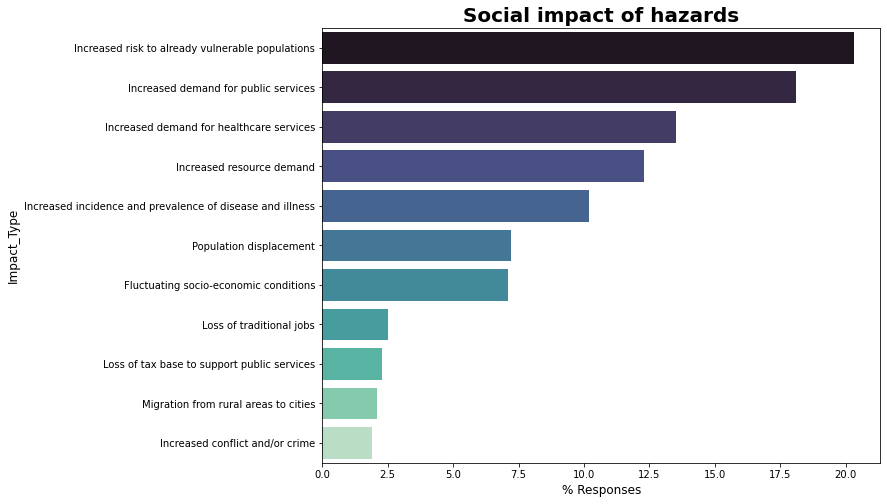

In [19]:
# select rows and get responses from dataframe
data = df.query('column_number == 5')
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "2.1",[5]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
top = perc.nlargest(11)


plt.figure(figsize=(10,8))
# Configure main plot
ax = plot_freq_of_cv(data=top, xlabel="% Responses", ylabel="Impact_Type",
                        title="Social impact of hazards", orient="h")

;



Of great importance is the consideration of the social influence of climate hazards. The graph shows the 11 most frequently mentioned answers. All other answers account for a share of less than 0.1% each. We can see that particularly vulnerable population groups are already at risk from climate change. We know that this group is already considered to be disproportionately disadvantaged in many other dimensions.

Population displacement is an impact that effects the socially disadvanteged part of a populations above average. Experience also shows that a potential lack of resources is first at the expense of disadvantaged groups. 

The loss of traditional jobs has a very concrete impact on social justice. So far, this impact has been described as low, but in connection with the Covid pandemic it can be assumed that especially members of the lower and middle classes are threatened by job loss. Climate-related effects could exacerbate this development in a threatening way.

Therefor we will focus on the following points:
- Increased risk to already vulnerable population
- Increased demand for healthcare service
- Increased resoure_demand
- Population Displacement
- Loss of traditional jobs
- Increased conflict / crime

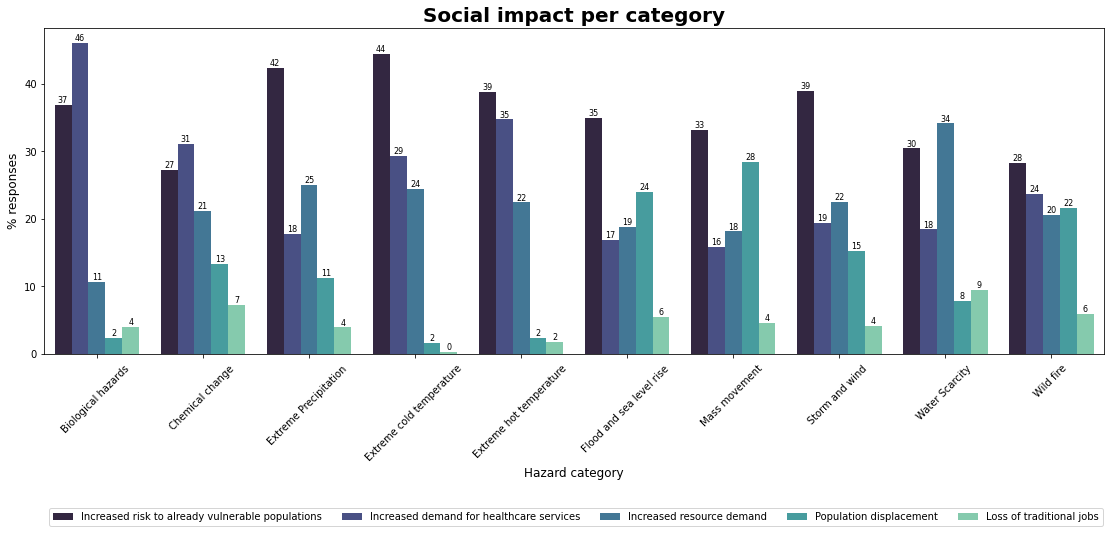

In [20]:
# select rows and get responses from dataframe
top_index = [
    'Increased risk to already vulnerable populations', 
    'Increased demand for healthcare services', 
    'Increased resource demand',
    'Population displacement', 
    'Loss of traditional jobs'
    ]
data = df.query('column_number == 1 | (column_number == 5 & response_answer == @top_index)')

# create dataframe with responser to columns 1 and 5 next to each others
comparison = compare_columns(data=data, questionnumber="2.1", select_col=1, compare_col=5)
comparison.rename(columns={"column_1":"hazard_cat", "column_5":"social_impact"}, inplace=True)

# group results by impact
gob = comparison.groupby(["hazard_cat","social_impact"]).count()
gob = gob.iloc[:,0]
gob_perc = gob.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
gob_perc = round(gob_perc, 1)
gob_perc = gob_perc.reset_index()
gob_perc


# Configure main plot
plt.figure(figsize=(19,6))
ax = sns.barplot(data=gob_perc, x="hazard_cat", y="select_key",hue = "social_impact", orient="v", palette="mako", hue_order=top_index) #xlabel="Frequency", ylabel="Climate Hazard",
                      #  title="Cities threatining Climate Hazards", orient="h", ax=ax_b1)
ax.set_xlabel("Hazard category",fontdict={"fontsize":rcParams["axes.labelsize"]})
ax.set_ylabel("% responses", fontdict={"fontsize":rcParams["axes.labelsize"]})
ax.set_title("Social impact per category", fontdict={"fontsize":rcParams["axes.titlesize"], "fontweight":rcParams["axes.titleweight"]})

ax.legend(loc='center left', bbox_to_anchor=(0, -0.5), ncol=5)
add_patches(ax)
rotate_labels(ax, "x", 45);


The social impacts of climate change threats are particularly evident in the health sector. This becomes particularly clear when considering the extreme weather conditions. Here, the negative effect is mostly related directly or indirectly to the health sector. 
We know that physical health and health care globally is highly dependent on personal prosperity. Measures to avoid health risks are therefore particularly preferable from a social point of view compared to other aspects.

The problem of water scarcity is also problematic. This impact affects third-world countries to a massive extent, which already have to cope with particular difficulties.

### Scoring

There will be two scores that will give a value to the fact, if a city deals with the fact if there are climate hazards with a social impact and if there are hazards, which vulnerable populations are affected by these hazards.

**s_score_1** Score for dealing with climate hazards with social impact.

**s_score_2** Score for dealing with vulnerable populations that are affected by these hazards.

Each answer provided by the cities will be valued as more acknowledgement of these facts and will count as an additional point. There is a maximum of five points and 0 points for missing answers.

In [21]:
#Creating s_scores

#Creating scoring function for s_score_1 and s_score_2
def create_score(x):
        if x == 1:
            return 1
        elif x == 2:
            return 2
        elif x == 3:
            return 3
        elif x == 4:
            return 4
        elif x >= 5:
            return 5
        else:
            return 1

#Creating subset of cir dataframe and collecting relevant answers for s_score_1
reduced = cir[((cir['question_number'] == '4.0a') & (cir['year'] == '2018')) | ((cir['question_number'] == '2.1') & ((cir['column_number'] == 5) | (cir['column_number'] == 10)) & ((cir['year'] == '2019') | (cir['year'] == '2020')))]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced_SI = reduced[((reduced['column_number'] == 5) & ((reduced['year'] == '2019') | (reduced['year'] == '2020'))) | ((cir['question_number'] == '4.0a') & (cir['year'] == '2018'))]

#Counting answers
reduced_SI = reduced_SI['select_key'].value_counts().to_frame()
reduced_SI['sum'] = reduced_SI['select_key']
reduced_SI['select_key'] = reduced_SI.index
reduced_SI.reset_index(inplace =True)

#Calculating s_score_1
reduced_SI['s_score_1'] = reduced_SI["sum"].apply(create_score)


#Creating subset of cir dataframe and collecting relevant answers for s_score_2
reduced_SII = reduced.query("column_number == 10")
reduced_SII = reduced_SII['select_key'].value_counts().to_frame()

#Counting answers
reduced_SII['sum'] = reduced_SII['select_key']
reduced_SII['select_key'] = reduced_SII.index
reduced_SII.reset_index(inplace =True)

#Calculating s_score_2
reduced_SII['s_score_2'] = reduced_SII["sum"].apply(create_score) 


#Merging s_score_1 and s_score_2 into one dataframe s_score
cid_red = cid.copy()
cid_red["select_key"] =cid_red["year"].astype(str)+"_"+cid_red["account_number"].astype(str)
cid_red = cid_red[['select_key']]
s_score   =     pd.merge(left = cid_red,
                     right = reduced_SI[['s_score_1']],
                     left_on = cid_red['select_key'],
                     right_on = reduced_SI['select_key'], 
                     how = 'left')
s_score = s_score[['select_key', 's_score_1']]
s_score   =     pd.merge(left = s_score,
                     right = reduced_SII[['s_score_2']],
                     left_on = s_score['select_key'],
                     right_on = reduced_SII['select_key'], 
                     how = 'left')
s_score = s_score[['select_key', 's_score_1', 's_score_2']]
s_score.fillna(0, inplace = True)

### Conclusion

Unfortunately, the survey does not provide information that would allow a comprehensive picture of the link between climate protection and social equity. Only the cities provide a small amount of information about their assessment of the threat situation with regard to social issues. From the available information, however, we can deduce that, from a risk perspective, measures that improve the health and resource supply of the population and can be reconciled with job retention are to be assessed as particularly fair.


## City-Business Collaboration

**Exploration Content**: <br/>
In this section, 


**Motivation Purpose**:<br/>
We follow the intuition that an effecive and holistic climate strategy requires cities and businesses to work together rather than alone. Firstly, this is because both cities and business pursue common interests and needs in their climate resilience planning. Simply put they thrive on a strong community and suffer under the negative of climate change on infrastructure, energy, food and water supplies and public health. Collaboration between cities and businesses is paramount as both bring complementary strength. Businesses operate much of the essential infrastructure, power, food and water supplies, and accumulate critical technical expertise upon which cities rely. Businesses are also influential political constituencies in cities, and having their support for the city’s climate resilience planning efforts can boost the overall political support for the process.

~ adapted from C2ES Guide to Public-Private Collaboration on City Climate Resilience Planning

We will beginn the collaboration assessment by investigating the question whether cities are already collaborating with businesses on climate action

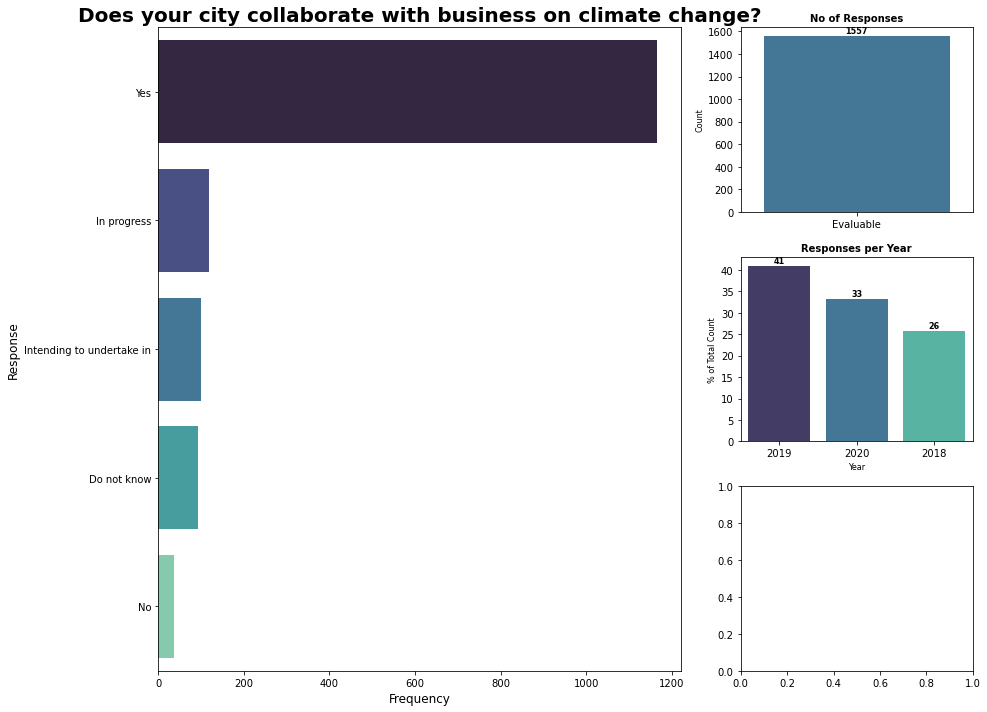

In [22]:
# create new dataframe, fetching only the information from the question whether a city is collaborating with businesses on climate action
# this information occurs in different question numbers for the different years
df6_2 = cir.query("(question_number == '6.2' and year == '2020') or (question_number == '6.1' and year == '2019') or (question_number == '5.1' and year == '2018')")

# select rows and get responses from dataframe
data = df6_2
answers = data.response_answer          
 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(5)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Does your city collaborate with business on climate change?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
#ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

From the graph we can derive that the overwhelming majority of cities are already or are at least in the progress of engaging with companies on climate topics. 

In [23]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cid_new = rename_and_merge(original_df=cid,
                 feature_df=df6_2,
                 feature="has_business_collaboration")

# visualize collaboration data using lat and lon data
# for simplification purposes we group the business collaboration answers
cid_new["has_business_collaboration"] = cid_new['has_business_collaboration'].str.replace('Not intending to undertake','No').replace("Intending to undertake in the next 2 years", "Intending to undertake in future")

fig = px.scatter_mapbox(cid_new, 
                     lat="lat",
                     lon="lon",
                     color=cid_new["has_business_collaboration"].fillna('NaN'),
                     labels="Has Business Collaboration",
                     hover_name="country",
                     zoom=0,
                     size="population",
                     title="Where do cities collaborate with businesses?",
                     mapbox_style='carto-darkmatter',
                     color_discrete_sequence= px.colors.diverging.Tropic,
                     height=600,
                     width=1000,
                     size_max=30)
fig.layout
fig.show()

Looking at the map, it is evident that city-business collaboration is far more prevalent in North America and Europe than it is in Asia.  

In [24]:
# Does city size matter for collaboration? 

bins = [1000, 10000, 50000, 250000, 1000000, 37500000]
cid_new['population_binned'] = pd.cut(cid_new['population'], bins, 
        labels=["1k to 10k citizens", 
                "10k to 50k citizens",
                "50k to 250k citizens",
                "250k up to 1m citizens",
                "More than 1m citizens"])
# Does city size matter for collaboration? 

df1 = cid_new.query("has_business_collaboration == 'Yes'")["population_binned"].value_counts().reset_index(name="collab_count")
df2 = cid_new["population_binned"].value_counts().reset_index(name="population_count")
df_population = pd.merge(df1, df2, on='index', how='left')
df_population

index  collab_count  population_count
0    50k to 250k citizens           387               684
1  250k up to 1m citizens           359               585
2   More than 1m citizens           240               375
3     10k to 50k citizens           148               316
4      1k to 10k citizens            28               101

In [25]:
# percentage distribution of cities collaborating with businessers
df_pop = (cid_new.query("has_business_collaboration == 'Yes'")["population_binned"].value_counts()/cid_new["population_binned"].value_counts()).reset_index(name="percentage_collab")

fig = px.bar(df_pop,
             x='index',
             y="percentage_collab",
             title="Proportion of cities collaborating with businesses by population size",
             text='percentage_collab',
             color_discrete_sequence= px.colors.sequential.Darkmint_r)
fig.update_traces(texttemplate='%{text:.0%}', textposition='inside')
fig.show()

**Findings**

At this point, we can denote several findings. Firstly, larger cities by population count appear to collaborate more frequently with businesses on climate topics compared to smaller ones. 
This seems reasonable, as larger cities tend to have more financial and human resources. 

Secondly, when looking at the locations where cities collaborate with businesses on climate topics, we see that cooperations are much more common in North & South America as well as Europe. In contrast, a large proportion of responding cities from Asia have either not provided an answer or are still in the progress of forming partnerships. 

We infer that, we ought to strengthening collaboration opportunities for smaller cities as well as who are located in areas where such partnerships are not the norm yet. 

### Collaboration Areas of Cities with Businesses

Q6.2a:'Please provide some key examples of how your city collaborates with business in the table below.'
------------------------------------------------------------------------------------------
1: 


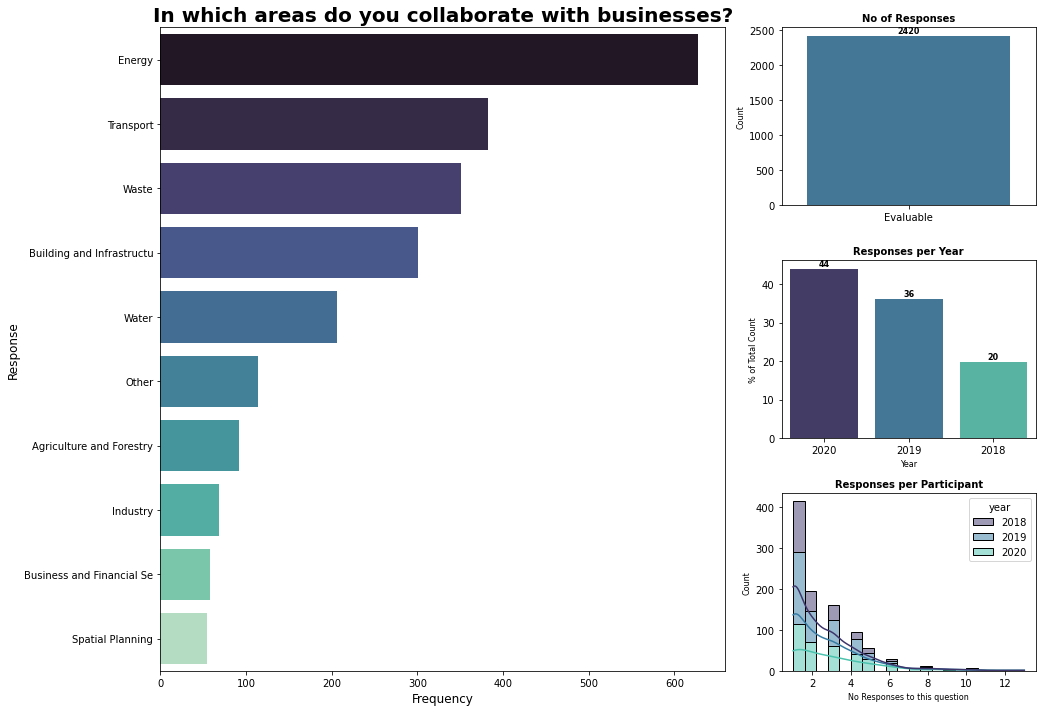

In [26]:
# create new dataframe, fetching only the information from the question on what topics cities are collaborating with businesses
# this information occurs in different question numbers for the different years
df6_2a = cir.query("(question_number == '6.2a' and year == '2020' and column_number == 1) or (question_number == '6.1a' and year == '2019' and column_number == 1) or (question_number == '5.1a' and year == '2018' and column_number == 1)")

# there is a long range of individual `Other` answers which will be grouped into a single other category
threshold_percent = 1
series = pd.value_counts(df6_2a['response_answer'])
mask = (series / series.sum() * 100).lt(threshold_percent)
df6_2a = df6_2a.assign(response_answer = np.where(df6_2a['response_answer'].isin(series[mask].index),'Other', df6_2a['response_answer']))

# merge slightly diverging response options from 2018 to 2020 into one reponse
df6_2a["response_answer"] = df6_2a['response_answer'].replace('Transport (Mobility)','Transport').replace('Buildings','Building and Infrastructure')

# select rows and get responses from dataframe
data = df6_2a
answers = data.response_answer          
 
# provide corrosponding question context
print_question(data, "6.2a", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="In which areas do you collaborate with businesses?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [27]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cid_new = rename_and_merge(original_df=cid_new,
                 feature_df=df6_2a,
                 feature="collaboration_area")

### Corporates' Value Chain Engagement on Climate Topics 

QC12.1:'Do you engage with your value chain on climate-related issues?'
------------------------------------------------------------------------------------------
a: 
l: 
l: 


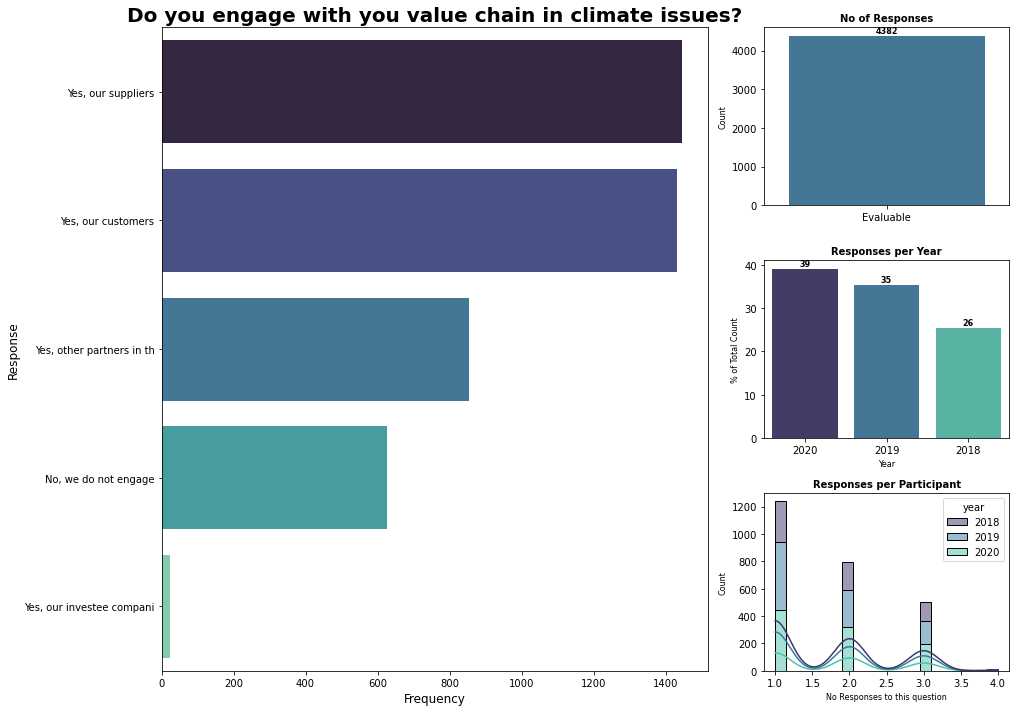

In [28]:
# extract information into new dataframe
dfC12_1 = cor.query("question_number == 'C12.1'")

#we deploy a function that splits the combined responses into its individual components and explodes them into the same column
dfC12_1 = split_response(df=dfC12_1, column="response_answer", sep=";") 
dfC12_1["response_answer"] = dfC12_1["response_answer"].str.lstrip()

# select rows and get responses from dataframe
data = dfC12_1
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1", columnnumber='all')     

# preprocess / calculate data for visualization
# we strip the left whitespaces from the response answer column
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with you value chain in climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [29]:
# rename response answer column in question-specific dataframe and map information to disclosure dataframe
cod_new = rename_and_merge(original_df=cod,
                           feature_df=dfC12_1,
                           feature="value_chain_engagement")

### How does the value chain engagement differ across industries? 

In [30]:
# are their differences across industries? 
df_value = cod_new[["year", "account_number", "primary_industry", "sectors", "industries", "value_chain_engagement"]]
df_value.drop_duplicates(inplace=True)

# create dataframe for each response option
df1 =  df_value.query("value_chain_engagement == 'Yes, our suppliers'")
df2 =  df_value.query("value_chain_engagement == 'Yes, our customers'")
df3 =  df_value.query("value_chain_engagement == 'No, we do not engage'")

# map the features to a new dataframe
df_full = (df1.groupby("primary_industry")["value_chain_engagement"].value_counts() / 
           df_value.groupby("primary_industry")["value_chain_engagement"].size()).reset_index(name="supplier_percent")

df_full["customer_percent"] = (df2.groupby("primary_industry")["value_chain_engagement"].value_counts() / 
                               df_value.groupby("primary_industry")["value_chain_engagement"].size()).reset_index(name="customer_percent")["customer_percent"]

df_full["suppliers_and_customers"] = df_full["supplier_percent"] + df_full["customer_percent"]

df_full["no_engagement"] = (df3.groupby("primary_industry")["value_chain_engagement"].value_counts() / 
                            df_value.groupby("primary_industry")["value_chain_engagement"].size()).reset_index(name="no_engagement")["no_engagement"]

# sort values by largest customer percent
df_full = df_full.sort_values(by="customer_percent", ascending=True)

fig = go.Figure()
fig.add_trace(
    go.Scatter(name= "Supplier Engagement Percentage", 
               x=df_full["supplier_percent"],
               y=df_full["primary_industry"], 
               mode='markers',
               marker=dict(size=df_full["suppliers_and_customers"]*50,
                           color='skyblue'))
               )

fig.add_trace(
    go.Scatter(name= "Customer Engagement Percentage", 
               x=df_full["customer_percent"],
               y=df_full["primary_industry"], 
               mode='markers',
               marker=dict(size=df_full["suppliers_and_customers"]*50,
                           color='mediumorchid'))
               )

fig.update_layout(height=800, 
                  width=1200, 
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                  title_text="Value Chain Engagement per Primary Industry")
fig.update_xaxes(showgrid=True, linewidth=0.5, linecolor='grey', title_text='Percentage of Engagement', tickformat=',.0%')
fig.update_yaxes(showgrid=True, linewidth=0.5, linecolor='grey')
#fig.update_traces(texttemplate='%{text:.0%}', textposition='inside')
fig.show()

In [31]:
df_full.sort_values(by="no_engagement",ascending=True, inplace=True)

# set different color for top 5 values
df_full["colors"] = 'mediumorchid'
df_full["colors"][7:12] = 'skyblue'

fig = go.Figure()
fig.add_trace(
    go.Scatter(name= "No Engagement Percentage", 
               x=df_full["no_engagement"],
               y=df_full["primary_industry"], 
               mode='markers',
               marker=dict(size=df_full["suppliers_and_customers"]*80,
                           color=df_full["colors"])))

fig.update_layout(height=800, 
                  width=800, 
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                  title_text="Percentage of Corporates per Industry with no Value Chain Engagement")

fig.update_xaxes(showgrid=True, linewidth=0.5, linecolor='grey', title_text='Percentage of Engagement', tickformat=',.0%')
fig.update_yaxes(showgrid=True, linewidth=0.5, linecolor='grey')
fig.show()


In [32]:
# create new data frame
dfC12_1a = get_response_pivot(data=cor,
                          questionnumber='C12.1a',
                          columnnumber='all',
                          pivot=False,
                          add_info=False,)

# replace all of the individual "other" specifications into a single "other" group
x = dfC12_1a.query("column_number == '1'")
dfC12_1a_grouped = x.replace(x.groupby('response_answer').sum().index[4:], 'Other')

QC12.1a:'Provide details of your climate-related supplier engagement strategy.'
------------------------------------------------------------------------------------------
1: 'C12.1a_c1-Type of engagement'
2: 'C12.1a_c2-Details of engagement'
3: 'C12.1a_c3-% of suppliers by number'
4: 'C12.1a_c4-% total procurement spend (direct and indirect)'
5: 'C12.1a_c5-% Scope 3 emissions as reported in C6.5'
 'C12.1a_c5-% of supplier-related Scope 3 emissions as reported in C6.5'
6: 'C12.1a_c6-Rationale for the coverage of your engagement'
7: 'C12.1a_c7-Impact of engagement, including measures of success'
8: 'C12.1a_c8-Comment'


QC12.1a:'Provide details of your climate-related supplier engagement strategy.'
------------------------------------------------------------------------------------------
1: 


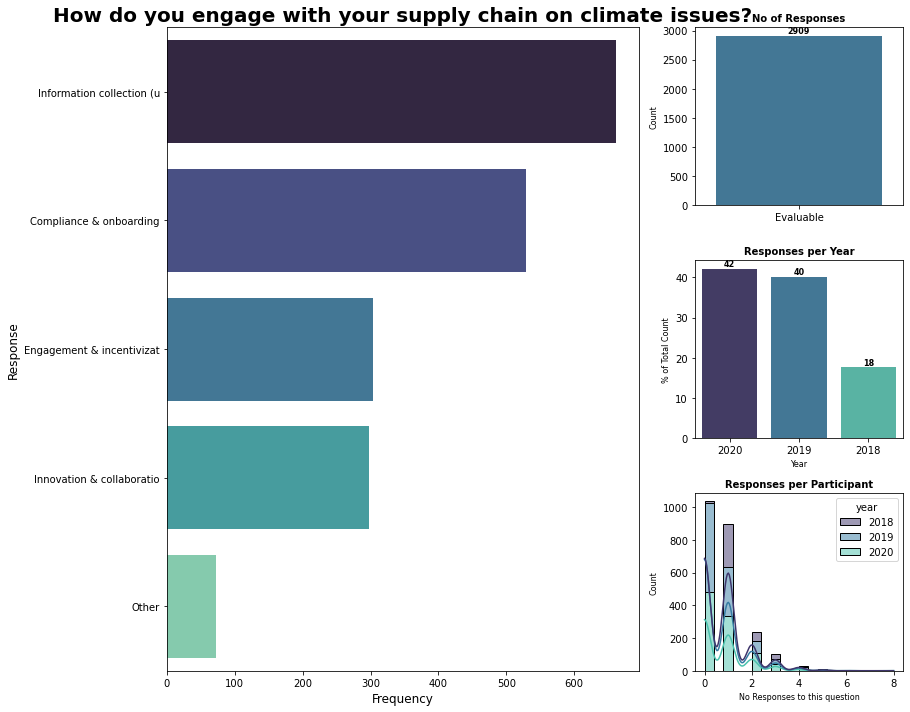

In [33]:
# select rows and get responses from dataframe
data = dfC12_1a_grouped.query("column_number == '1'")
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.1a", columnnumber='1')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="How do you engage with your supply chain on climate issues?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [34]:
# save results to disclosure dataframe
cod_new = rename_and_merge(original_df=cod_new,
                 feature_df=dfC12_1a_grouped,
                 feature="supply_chain_engagement")

The results are derived from analyzing the supply chain engagement of corporates are noteworthy. Seemingly companies focus their collaboration with the supply chain on climate topics on collecting information and compliance rather than trying to truly change either the individual suppliers behavor or the market as a whole. Co-creating **innovative climate-friendly** or carbon neutral solutions with their suppliers is arguably a far greater step towards truely changing the company'footprint along the supply chain. However, as of now it appears that only few companies are already pursuing this path. 

### Policy Engagement of Corporates by Industry

Lastly, we will examine whether corporates not only engage with suppliers and customers but also with policy makers. This information is vital in determining ways of collaboration between corporates and cities. However, this part is particularly sensible. Corporate influence on policy makers is not always associated with a **pro-climate position**. In contrast, corporates spend millions each year to impede the implementation of stricter regulation. 

Fortunately, the survey contains the question on what position companies take in their engagement with policy makers. Though not a perfect indicator, this information give a guideline in which direction the collaboration between corporates and policy makers is heading.

#### Do corporates engage with policy makers?

In [35]:
df = cor.query("question_number == 'C12.3'")

# apply function to split connected responses and clean whitespaces
df = split_response(df=df, column="response_answer", sep=";")

df["response_answer"] = df["response_answer"].str.lstrip()

QC12.3:'Do you engage in activities that could either directly or indirectly influence public policy on climate-related issues through any of the following?'
------------------------------------------------------------------------------------------
a: 
l: 
l: 


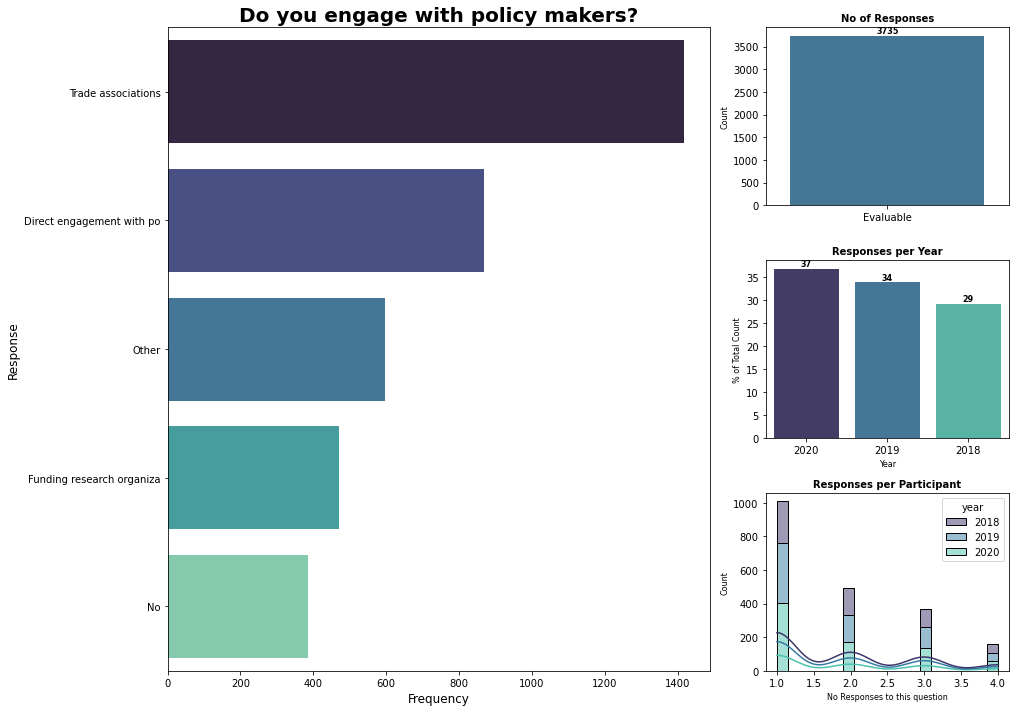

In [36]:
# select rows and get responses from dataframe
data = df
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.3", columnnumber='all')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
        
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Do you engage with policy makers?",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [37]:
# save results to disclosure dataframe
cod_new = rename_and_merge(original_df=cod_new,
                 feature_df=df,
                 feature="policy_engagement")

QC12.3a:'On what issues have you been engaging directly with policy makers?'
------------------------------------------------------------------------------------------
2: 


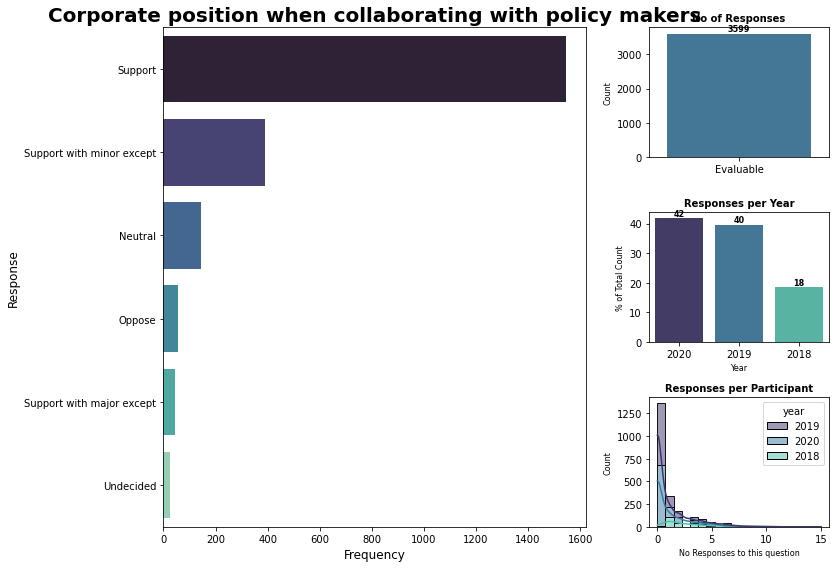

In [38]:
df = cor.query("question_number == 'C12.3a' and column_number == '2'")

data = df
answers = data.response_answer          

# provide corrosponding question context
print_question(data, "C12.3a", columnnumber='2')   

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
val = val.nlargest(10)                     # get top 10 values

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(12,8), orient="vertical")

# plot results
ax_b1 = plot_freq_of_cv(
                data=val, 
                xlabel="Frequency", 
                ylabel="Response", 
                title="Corporate position when collaborating with policy makers",
                orient="h",
                ax=ax_b1
        );
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)
plt.tight_layout();
cut_labels(fig=ax_b1, 
           axis="y",
           max_length=25)
plt.show();

In [39]:
# save results to disclosure dataframe
cod_new = rename_and_merge(original_df=cod_new,
                           feature_df=df,
                           feature="policy_engagement_position")

#### How does corporate policy engagement differ across industries?

In [40]:
# are their differences across industries? 
df_policy = cod_new[["year", "account_number", "primary_industry", "sectors", "industries", "policy_engagement", "policy_engagement_position"]]
df_policy.drop_duplicates(inplace=True)

# create dataframe for each response option
df1 =  df_policy.query("policy_engagement == 'Direct engagement with policy makers'")
df2 =  df_policy.query("(policy_engagement_position == 'Support') or (policy_engagement_position == 'Support with minor except')")
df3 =  df_policy.query("(policy_engagement_position == 'Oppose') or (policy_engagement_position == 'Neutral') or (policy_engagement_position == 'Undecided')")


# map the features to a new dataframe
df_full = (df1.groupby("primary_industry")["policy_engagement"].value_counts() / 
           df_policy.groupby("primary_industry")["policy_engagement"].size()).reset_index(name="policy_engagement_percent")

df_full["support"] = (df2.groupby("primary_industry")["policy_engagement_position"].value_counts() / 
                               df_policy.groupby("primary_industry")["policy_engagement_position"].size()).reset_index(name="support_percent")["support_percent"]

df_full["oppose"] = (df3.groupby("primary_industry")["policy_engagement_position"].value_counts() / 
                               df_policy.groupby("primary_industry")["policy_engagement_position"].size()).reset_index(name="oppose_percent")["oppose_percent"]

# drop industry 'International bodies' because it has too few observations
df_full = df_full.query("primary_industry != 'International bodies'")




In [41]:
# sort values policy engagement percent
df_full.sort_values(by="policy_engagement_percent", ascending=True,  inplace=True)

# set different color for top 5 values
df_full["colors"] = 'mediumorchid'
df_full["colors"][7:12] = 'skyblue'

fig = go.Figure()
fig.add_trace(
    go.Scatter(name= "Percentage of Direct Policy Engagement", 
               x=df_full["policy_engagement_percent"],
               y=df_full["primary_industry"], 
               mode='markers',
               marker=dict(size=df_full["support"]*80,
                           color=df_full["colors"])))

fig.update_layout(height=800, 
                  width=800, 
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                  title_text="Corporates with Direct Policy Engagement by Industry")

fig.update_xaxes(showgrid=True, linewidth=0.5, linecolor='grey', title_text='Percentage of Engagement', tickformat=',.0%')
fig.update_yaxes(showgrid=True, linewidth=0.5, linecolor='grey')
fig.show()


Interestingly, we see that **fossile fuel** companies have the highest percentage of **direct policy engagement** regarding climate-related topics while having among the **lowest support rate** with policy makers. 

### Scoring

In the following, we will assign values for each of the added features in an attempt to create a scoring system for the collaborative efforts of cities. 

More specifically, we will be looking at the columns `has_business_collaboration` and `collaboration_area`. 

Starting with `has_business_collaboration`, we will conduct a scoring from 1 to 5 with 1 being the lowest score which is attributed if there is no response given and 5 meaning that there is a business collaboration already in place. The scoring methodology is as follows:

* 0: no response
* 1: No / Not intending to undertake / Do not know
* 2: Intending to undertake in future
* 3: Intending to undertake in the next 2 years
* 4: In progress
* 5: Yes

As for `collaboration_area` there is not enough information provided to make a clear and reliable distinction between the separate topics. However, following the idea of a holistic approach to address a climate change, we perceive that it is favorable if cities cooperate with businesses on multiple areas. Accordingly, we assign the following scores: 

* 0: no response
* 1: one collaboration area
* 2: two collaboration areas
* 3: three collaboration areas
* 4: four to five collaboration areas 
* 5: more that five collaboration areas

Finally, we will aggregate the results in a final `city_collaboration_score` that will guide us in how well a particular city performs.

In [42]:
# assign scores for each response option
scores = {'nan': 0,
          'No' :1, 
          'Not intending to undertake' :1,
          'Do not know' :1,
          'Intending to undertake in future':2,
          'Intending to undertake in the next 2 years' :3,
          'In progress':4,
          'Yes':5}

# create new business collaboration measure by mapping the scores to the respective response
cid_new["has_business_collaboration_score"] = cid_new["has_business_collaboration"].map(scores)

# create a select key on which the information is mapped on
cid_new["select_key"] =cid_new["year"].astype(str)+"_"+cid_new["account_number"].astype(str)

# compute the sum of entries of all individual collaboration areas and add each of them as new columns
cid_new = cid_new.join(pd.crosstab(cid_new["select_key"], cid_new["collaboration_area"]), on="select_key")

# this computes the sum of all individual columns
cid_new["sum_area"] = cid_new.iloc[:,19:].sum(axis=1)

# assign the respective score for each number of counts
def create_score(x):
        if x == 1:
            return 1
        elif x == 2:
            return 2
        elif x == 3:
            return 3
        elif x == 4 or x == 5:
            return 4
        elif x > 5:
            return 5
        else:
            return 0

cid_new["collaboration_area_score"] = cid_new["sum_area"].apply(create_score)

#drop all helper columns from the dataframe
cid_new.drop(['Other', 'Energy', 'Water', 'Waste', 'Transport',
       'Industry', 'Agriculture and Forestry',
       'Building and Infrastructure', 'Spatial Planning',
       'Social Services', 'Business and Financial Services', 'sum_area'], axis=1, inplace=True)

#create final collaboration score table for cities
cid_scores = cid_new[["account_number", "year", "has_business_collaboration_score", "collaboration_area_score"]]
# remove all duplicate entries that originate from the multi-row responses
cid_scores.drop_duplicates(inplace=True)
cid_scores.rename(columns={'has_business_collaboration_score': 'c_score_1', 'collaboration_area_score': 'c_score_2'}, inplace=True)
cid_scores = cid_new[["account_number", "year", "has_business_collaboration_score", "collaboration_area_score"]]
# remove all duplicate entries that originate from the multi-row responses
cid_scores.drop_duplicates(inplace=True)
cid_scores.rename(columns={'has_business_collaboration_score': 'c_score_1', 'collaboration_area_score': 'c_score_2'}, inplace=True)

cid_scores.to_pickle("data/cid_scores.pkl", protocol=4)

Next, we will assign values for each of the added features in an attempt to create a scoring model for the collaborative efforts of corporates. 

More specifically, we will be looking at the columns `value_chain_engagement`, `customer_engagement`, `supply_chain_engagement`, and `policy_engagement`. 

Starting with `value_chain_engagement`, we will conduct a scoring from 1 to 5 with 1 being the lowest score which is attributed if there is no response given and 5 meaning that the company engages with both suppliers and customers. The scoring methodology is slightly more complicated compared to the previous models and is computed as follows:

* 0: No response
* 1: No, we do not engage
* 2: Yes, our investee companies or Yes, other partners in our value chain while both Yes, our customers and Yes, our suppliers are not included
* 3: Either Yes, our Suppliers or Yes, our Customers
* 4: Both Yes, our Suppliers and Yes, our Customers
* 5: All of Yes, our Supplier, Yes, our Customers and Yes, other partners in our value chain

In [43]:
# create new dataframe with value chain engagement responses
df_value = cor.query("question_number == 'C12.1'")[["account_number", "year", "entity", "response_answer"]]

# split response answer entries into individual response
df_value = split_response(df=df_value, column="response_answer", sep=";") 
df_value["response_answer"] = df_value["response_answer"].str.lstrip()

# create select key for mapping the response
df_value["select_key"] =df_value["year"].astype(str)+"_"+df_value["account_number"].astype(str)
cod_new["select_key"] =cod_new["year"].astype(str)+"_"+cod_new["account_number"].astype(str)

# compute the sum of entries of all individual collaboration areas and add each of them as new columns
df_value = df_value.join(pd.crosstab(df_value["select_key"], df_value["response_answer"]), on="select_key")

# define a function to convert our response methodology to scores 
def conditions(s):
    if s["No, we do not engage"] >=1: 
        return 1
    elif ((s["Yes, our investee companies"] >=1) or (s["Yes, other partners in the value chain"]>=1)) and ((s["Yes, our customers"] == 0) and (s["Yes, our suppliers"] == 0)): 
        return 2
    elif ((s["Yes, our customers"] >= 1) or (s["Yes, our suppliers"] >= 1)) and ((s["Yes, our investee companies"] == 0) and (s["Yes, other partners in the value chain"]==0)): 
        return 3
    elif ((s["Yes, our customers"] >= 1) and (s["Yes, our suppliers"] >= 1)) and ((s["Yes, our investee companies"] == 0) and (s["Yes, other partners in the value chain"]==0)): 
        return 4
    elif ((s["Yes, our customers"] >= 1) and (s["Yes, our suppliers"] >= 1)) and ((s["Yes, our investee companies"] >= 1) or (s["Yes, other partners in the value chain"]>=1)): 
        return 5
    else: 
        return 0

# apply the function to create value chain scores
df_value['value_chain_score'] = df_value.apply(conditions, axis=1)

# create new dataframe with corporate collaboration scores including the new value chain score
cod_scores = df_value[["account_number", "year", "value_chain_score"]]

# remove duplicate entries for each year
cod_scores.drop_duplicates(inplace=True)

### supply chain score ###

df_supply = cor.query("question_number == 'C12.1a' and column_number == 1")[["account_number", "year", "entity", "response_answer"]]

# Combine all the `other. please specify` responses into one `Other` category
df_supply = df_supply.replace(df_supply.groupby('response_answer').sum().index[4:], 'Other')

# define scoring system
scores = {'NaN': 0,
          'Compliance & onboarding' :1, 
          'Information collection (understanding supplier behavior)' :2,
          'Engagement & incentivization (changing supplier behavior)':4,
          'Innovation & collaboration (changing markets)' :5,
          'Other':3}

# maps scores to the respective response answer
df_supply["supply_score"] = df_supply["response_answer"].map(scores)

# choose max score for each entitiy in each year
df_supply['supply_chain_score'] = df_supply.groupby(['account_number', 'year'])['supply_score'].transform(np.max)

# create merge keys
df_supply["select_key"] = df_supply["year"].astype(str) + "_" + df_supply["account_number"].astype(str)
cod_scores["select_key"] = cod_scores["year"].astype(str) + "_" + cod_scores["account_number"].astype(str)

# merge new supply chain score to disclosure dataframe
cod_scores = pd.merge(left=cod_scores,
                   right= df_supply["supply_chain_score"],
                   left_on=cod_scores["select_key"],
                   right_on=df_supply["select_key"],
                   how="left")
cod_scores.drop_duplicates(inplace=True)

# drop the unneccessary columns
cod_scores.drop("key_0", axis=1, inplace=True)

### customer score ###

df_customer = cor.query("question_number == 'C12.1b' and column_number == 1")[["account_number", "year", "entity", "response_answer"]]

# replace all of the individual "other" specifications into a single "other" group
df_customer = df_customer.replace(df_customer.groupby('response_answer').sum().index[5:], 'Other')

# we merge the two Education/information sharing response options into one response
df_customer["response_answer"] = df_customer['response_answer'].str.replace('Education/information sharing : Engagement','Education/information sharing')

# we assign values for each response option
scores = {'nan': 0, 
          'Information collection (understanding customer behavior)' :1,
          'Education/information sharing' : 2,
          'Engagement & incentivization (changing customer behavior)':4,
          'Collaboration & innovation' :5,
          'Other':3}

# maps scores to the respective response answer
df_customer["customer_score"] = df_customer["response_answer"].map(scores)

# choose max score for each entitiy in each year
df_customer['customer_score'] = df_customer.groupby(['account_number', 'year'])['customer_score'].transform(np.max)

# create select key for merging to disclosure dataframe
df_customer["select_key"] = df_customer["year"].astype(str)+"_"+df_customer["account_number"].astype(str)

# create select key for merging to collaboration scoring dataframe
df_customer["select_key"] = df_customer["year"].astype(str)+"_"+df_customer["account_number"].astype(str)

# merge new supply chain score to disclosure dataframe
cod_scores = pd.merge(left=cod_scores,
                   right= df_customer["customer_score"],
                   left_on=cod_scores["select_key"],
                   right_on=df_customer["select_key"],
                   how="left")
cod_scores.drop_duplicates(inplace=True)

# drop the unneccessary columns
cod_scores.drop("key_0", axis=1, inplace=True)

For **policy engagement** the scoring is a little more compicated and even more subjective compared to the other value chain engagement scores. 
Again, we follow our perspective that climate resilience is enhanced when businesses and policy makers work together rather than alone. However, as denoted by the think tank InfluenceMap, only few of the influential corporations are positively engaging on climate policy globally, with most holding either a neutral or negative perspective. This makes a coherent scoring more difficult. One the one hand side, we intend to promote purposeful engagement of corporates with policy makers. On the other hand-side, we only perceive those policy engagements as positive where businesses support the view of local policy makers. Unfortunately, the data provided offers this information for the response option *Direct engagment with policy makers*.

To account for this view, we focus on the direct engagement with policy makers and combine the response with the corporate position with policy decisions. Ultimately, we apply the following scoring methodology:

* 1: No
* 2: Trade associations / Funding research organizations / Direct engagement with policy makers & either no corporate position provided or position is opposing/neutral/undecided 
* 3: Direct engagement with policy makers & support with major exceptions
* 4: Direct engagmenet with policy makers & support with minor exceptions
* 5: Direct engagement with policy makers & supportive corporate position

**Note:**

In the next step, we create a helper column that defines the majority position that a companies takes on policy views. This is necessary given that it is a multi-response column, thus, a single company can have multiple position in a year. This is because each position is assigned to a policy topic (e.g. Energy). For simplification purposes, we take the majority position that a corporate holds in a year. 

In [44]:
# extract question from response dataset into separate dataframe
df_policy = cor.query("question_number == 'C12.3'")[["account_number", "year", "entity", "response_answer"]]

# split chained response answers
df_policy = split_response(df=df_policy, column="response_answer".lstrip(), sep=";")

# remove whitespaces infront of response options
df_policy["response_answer"] = df_policy["response_answer"].str.lstrip()

# create select key to match information
df_policy["select_key"] =df_policy["year"].astype(str)+"_"+df_policy["account_number"].astype(str)

# create new dataframe for the corporate position
df_position = cor.query("question_number == 'C12.3a' and column_number == 2")[["account_number", "year", "response_answer"]]

# create merge key
df_position["select_key"] =df_position["year"].astype(str)+"_"+df_position["account_number"].astype(str)

# convert response options to columns
df_position = df_position.join(pd.crosstab(df_position["select_key"], df_position["response_answer"]), on=df_position["select_key"])

## build helper column ## 

# create a helper column with majority position
df_position["majority_position"] = df_position[["Neutral", "Oppose", "Support", "Support with major exceptions", "Support with minor exceptions", "Undecided"]].idxmax(1)

# merge majority position to policy dataframe
df_policy = pd.merge(left=df_policy,
                   right= df_position["majority_position"],
                   left_on=df_policy["select_key"],
                   right_on=df_position["select_key"],
                   how="left")
df_policy.drop_duplicates(inplace=True)

# define the conditions based on which scores are assigned
conditions = [df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("Support"), 
              df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("Oppose"),
              df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("Undecided"),
              df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("Neutral"),
              df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("NaN"),
              df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("Support with minor exceptions"),
              df_policy["response_answer"].eq("Direct engagement with policy makers") & df_policy["majority_position"].eq("Support with major exceptions"),
              df_policy["response_answer"].eq("Funding research organizations") | df_policy["response_answer"].eq("Trade associations"),
              df_policy["response_answer"].eq("Other"),
              df_policy["response_answer"].eq("No")]

choices = [5, 2, 2, 2, 2, 4, 3, 2, 2, 1]

df_policy["policy_score"] = np.select(conditions, choices, default=0)

# choose max score for each entitiy in each year
df_policy['policy_score'] = df_policy.groupby(['account_number', 'year'])['policy_score'].transform(np.max)

# merge final policy score results to collaboration scoring dataframe
cod_scores = pd.merge(left=cod_scores,
                   right= df_policy["policy_score"],
                   left_on=cod_scores["select_key"],
                   right_on=df_policy["select_key"],
                   how="left")
cod_scores.drop_duplicates(inplace=True)

# drop the unneccessary columns
cod_scores.drop("key_0", axis=1, inplace=True)

### final corporate collaboration dataframe ###

cod_scores.rename(columns={'value_chain_score': 'c_score_3', 'customer_score': 'c_score_4', 'supply_chain_score': 'c_score_5', 'policy_score': 'c_score_6'}, inplace=True)
cod_scores.drop("select_key", axis=1, inplace=True)

cod_scores.to_pickle("data/cod_scores.pkl", protocol=4)

## Opportunities

**Exploration Content**: <br/>
The analysis of risks is followed by an examination of opportunities from the perspective of cities and companies. We will examine where both sides see their individual opportunities, how high they rate them and where there are overlaps between the two sides' views.

**Motivation Purpose**:<br/>
The greatest motivation for cooperation arises when all participants benefit from it. It is therefore important to look not only at security but also at opportunities on all sides. 
From a communication point of view alone, it seems promising to pay special attention to the shared possibilities and opportunities. It could be way easier to convince partners to collaborate, if both sides see a change to benefit from collaboration.

Q6.0:'Do you have an emissions inventory for your local government operations to report?'
 'Please indicate the opportunities your city has identified as a result of addressing climate change and describe how the city is positioning itself to take advantage of these opportunities.'
------------------------------------------------------------------------------------------
0: nan
1: 'Opportunity'
2: 'Describe how the city is maximizing this opportunity'
Q6.0:'Please indicate the opportunities your city has identified as a result of addressing climate change and describe how the city is positioning itself to take advantage of these opportunities.'
------------------------------------------------------------------------------------------
1: 'Opportunity'


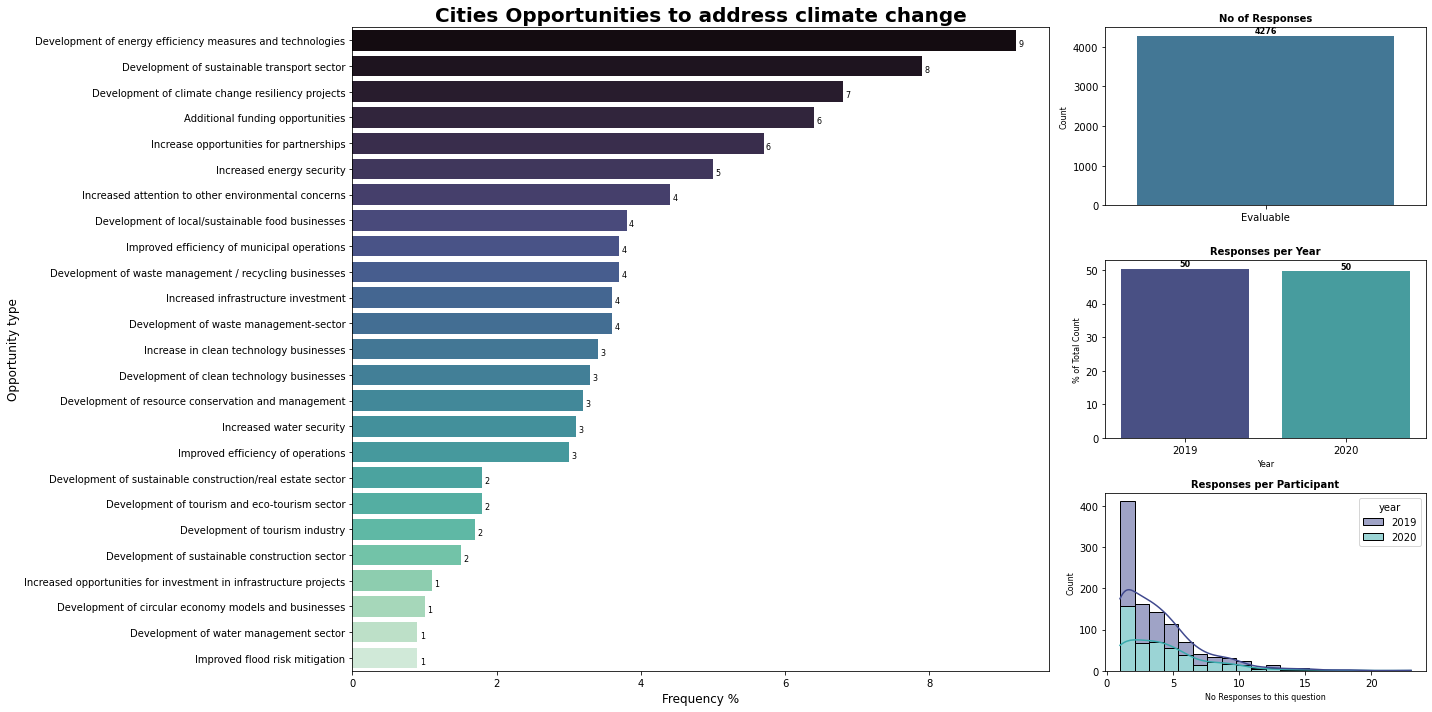

Number responses:4276
Answers reflected by plot: 90.50000000000001%


In [45]:
# get dataframe with relevant questions
df = get_response_pivot(data=cir, questionnumber="6.0", columnnumber="all", pivot=False)

# select rows and get responses from dataframe
data = df.query('column_number == 1')
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "6.0",[1]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
top = perc.nlargest(25)

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(20,10), orient="vertical")

# Configure main plot
ax_b1 = plot_freq_of_cv(data=top, xlabel="Frequency %", ylabel="Opportunity type",
                        title="Cities Opportunities to address climate change", orient="h", ax=ax_b1)

add_patches(ax_b1, orient="h")
# Calculate basic plots
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)

plt.tight_layout();
plt.show();
print("Number responses:" + str(len(data)))
print("Answers reflected by plot: "+str(top.sum())+"%");

The possibilities identified by cities for addressing climate change are manifold and can be roughly divided into "concrete measures" and "general conditions". It is noticeable that a great many possibilities concern the area of "technology development". Support in this area could certainly be of interest to companies and help them to develop new business models and products.

As usual, the focus of public innovation efforts is on encouraging cooperation and providing funding.

### Corporates

QC2.4a:'Provide details of opportunities identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
1: 'C2.4a_c1-Identifier'
2: 'C2.4a_c2-Where in the value chain does the opportunity occur?'
3: 'C2.4a_c3-Opportunity type'
4: 'C2.4a_c4-Primary climate-related opportunity driver'
5: 'C2.4a_c5-Type of financial impact driver'
 'C2.4a_c5-Type of financial impact'
 'C2.4a_c5-Primary potential financial impact'
6: 'C2.4a_c6-Company- specific description'
 'C2.4a_c6-Company-specific description'
7: 'C2.4a_c7-Time horizon'
8: 'C2.4a_c8-Likelihood'
9: 'C2.4a_c9-Magnitude of impact'
10: 'C2.4a_c10-Potential financial impact'
 'C2.4a_c10-Are you able to provide a potential financial impact figure?'
11: 'C2.4a_c11-Explanation of financial impact'
 'C2.4a_c11-Potential financial impact figure (currency)'
12: 'C2.4a_c12-Strategy to realize opportunity'
 'C2.4a_c12-Pot

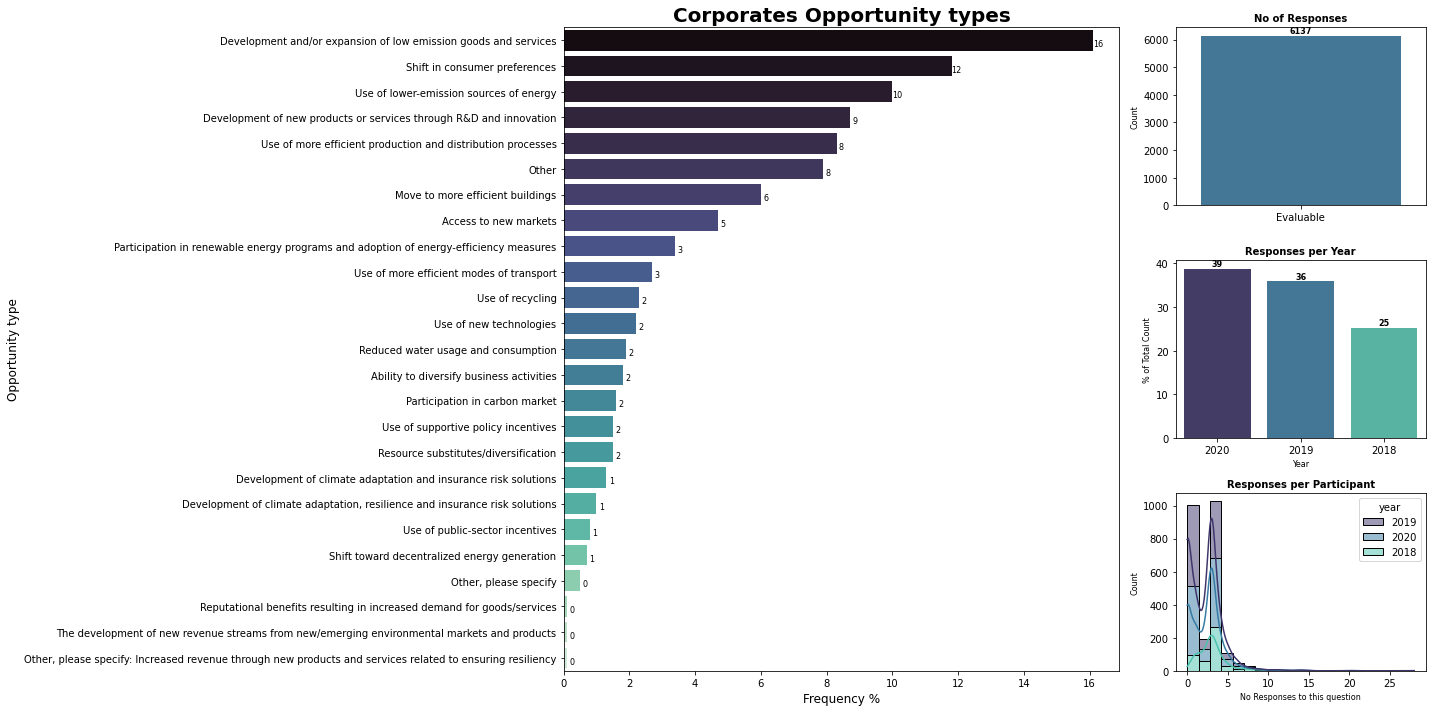

Number responses:6137
Answers reflected by plot: 97.0%


In [46]:
# get dataframe with relevant questions
df = get_response_pivot(data=cor, questionnumber="C2.4a", columnnumber="all", pivot=False)

# select rows and get responses from dataframe
data = df.query('column_number == 4')
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "2.4a",[4]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
top = perc.nlargest(25)

# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(20,10), orient="vertical")

# Configure main plot
ax_b1 = plot_freq_of_cv(data=top, xlabel="Frequency %", ylabel="Opportunity type",
                        title="Corporates Opportunity types", orient="h", ax=ax_b1)

add_patches(ax_b1, orient="h")
# Calculate basic plots
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)

plt.tight_layout();
plt.show();
print("Number responses:" + str(len(data)))
print("Answers reflected by plot: "+str(top.sum())+"%");

It is not surprising that the company considers "Products & Service" as well as "Resource Efficiency" by a large majority as the areas with the most opportunities: Both have a direct impact on value creation and represent the core of companies. Accordingly, this is also where the sphere of influence is greatest and optimisation is most promising. It is striking that these categories very clearly correspond to the concerns identified by the cities. 

### Where do climate opportunities overlap between cities and corporates?

![corporates image](figures/Opportunities_cities_corporates.png)

There is a strong overlap in perceived opportunities by both cities and corporates in **Clean Technology & Products** as well as fostering **Energer & Operations Efficiency**. 
Both topics might be interesting collaboration areas. On the contrary, corporates are far more market oriented as cities while cities see more value in strengthening the **Climate Change Resiliency** 

### Scoring
There will be five scores for companies that will provide a value to oportunity affairs within corporations.

**o_score_1** will provide a value to the fact if the corporation has identified an climate related oportunity with an impact of the business. There will be five points if so. One point, if not. And zero points, for missing answers.

**o_score_2** will provide a value to the number of oportunity types, that are identified by the corporation. Each one identified, will count as a point, with a maximum of five points and zero points for missing answers.

**o_score_3** will provide a value to the time horizon seen by the corporation for the oportunity.

There will be: 

- five points for current oportunities
- four for short-term
- three for medium term
- two for longterm
- one for unknown time horizons 
- and zero for missing answers.

**o_score_4** will provide a value to the liklihood that sees the corporation for the oportunity.

There will be:

- five points for virtually certain
- four points for very likely
- three points for likely
- two points for more likely than not
- one point for other answers
- and zero points for missings answers.

**o_score_5** will provide a value to identified drivers of oportunities by the corporation. Each one identified, will count as a point, with a maximum of five points and zero points for missing answers.


In [47]:
#Creating o_scores

#Creating scoring function for o_score_1
def create_score(x):
    if x == 'No':
        return 1
    elif x == 'Yes':
        return 5
    else:
        return 0
    

#Creating subset of cor dataframe and collecting relevant answers for o_score_1
reduced = cor[(cor['question_number'] == 'C2.4') & (cor['theme'] == 'climate')]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Calculating o_score_1
reduced['response_answer'] = reduced["response_answer"].apply(create_score) 
reduced_O1 = reduced

#Collecting answers in separate dataframe
reduced_O1.rename(columns={'response_answer':'o_score_1'}, inplace=True)
reduced_O1.reset_index(inplace=True)



#Creating scoring function for o_score_2
def create_score(x):
        if x == 1:
            return 1
        elif x == 2:
            return 2
        elif x == 3:
            return 3
        elif x == 4:
            return 4
        elif x >= 5:
            return 5
        else:
            return 0
        

#Creating subset of cor dataframe and collecting relevant answers for o_score_2
reduced = cor[(cor['question_number'] == 'C2.4a') & (cor['column_number'] == 3) & (cor['theme'] == 'climate')]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Counting answers
reduced = reduced['select_key'].value_counts().to_frame()
reduced['sum'] = reduced['select_key']
reduced['select_key'] = reduced.index
reduced.reset_index(inplace =True)
reduced['o_score_2'] = reduced["sum"].apply(create_score) 

#Collecting answers in separate dataframe
reduced_O2 = reduced 
reduced_O2.reset_index(inplace = True)



#Creating scoring function for o_score_3
def create_score(x):
        if x == 'Short-term':
            return 4
        elif x == 'Medium-term':
            return 3
        elif x == 'Current':
            return 5
        elif x == 'Long-term':
            return 2
        elif x == 'Unknown':
            return 1
        else:
            return 0
        

#Creating subset of cor dataframe and collecting relevant answers for o_score_3
reduced = cor[(cor['question_number'] == 'C2.4a') & (cor['column_number'] == 7) & (cor['theme'] == 'climate')]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Calculating o_score_3
reduced['response_answer'] = reduced["response_answer"].apply(create_score) 

#Collecting answers in separate dataframe
reduced_O3 = reduced
reduced_O3.rename(columns={'response_answer':'o_score_3'}, inplace=True)
reduced_O3.reset_index(inplace=True)

#Calculating mean value for points for corporations with multiple answers
reduced_O3 = reduced_O3.groupby('select_key')['o_score_3'].agg(['sum','count'])
reduced_O3['o_score_3'] = reduced_O3['sum'] / reduced_O3['count']
reduced_O3['o_score_3'] = reduced_O3.o_score_3.apply(round)
reduced_O3['select_key'] = reduced_O3.index



#Creating scoring function o_score_4
def create_score(x):
        if x == 'About as likely as not':
            return 1
        elif x == 'More likely than not':
            return 2
        elif x == 'Likely':
            return 3
        elif x == 'Very likely':
            return 4
        elif x == 'Virtually certain':
            return 5
        else:
            return 0
        

#Creating subset of cor dataframe and collecting relevant answers for o_score_4
reduced = cor[(cor['question_number'] == 'C2.4a') & (cor['column_number'] == 8) & (cor['theme'] == 'climate')]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Calculating o_score_4
reduced['response_answer'] = reduced["response_answer"].apply(create_score) 

#Collecting answers in separate dataframe
reduced_O4 = reduced
reduced_O4.rename(columns={'response_answer':'o_score_4'}, inplace=True)

#Calculating mean value for points for corporations with multiple answers
reduced_O4 = reduced_O4.groupby('select_key')['o_score_4'].agg(['sum','count'])
reduced_O4['o_score_4'] = reduced_O3['sum'] / reduced_O3['count']
reduced_O4['o_score_4'] = reduced_O3.o_score_3.apply(round)
reduced_O4['select_key'] = reduced_O4.index



#Creating scoring function for o_score_5
def create_score(x):
        if x == 1:
            return 1
        elif x == 2:
            return 2
        elif x == 3:
            return 3
        elif x == 4:
            return 4
        elif x >= 5:
            return 5
        else:
            return 0
        

#Creating subset of cor dataframe and collecting relevant answers for o_score_5
reduced = cor[(cor['question_number'] == 'C2.4a') & (cor['column_number'] == 4) & (cor['theme'] == 'climate')]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Counting answers
reduced = reduced['select_key'].value_counts().to_frame()
reduced['sum'] = reduced['select_key']
reduced['select_key'] = reduced.index
reduced.reset_index(inplace =True)

#Collecting answers in separate dataframe
reduced['o_score_5'] = reduced["sum"].apply(create_score) 
reduced_O5 = reduced



#Merging o_scores to one seperate dataframe o_score_co
cod_red = cod[cod['theme'] == 'climate']
cod_red["select_key"] =cod_red["year"].astype(str)+"_"+cod_red["account_number"].astype(str)
cod_red = cod_red[['select_key']]
cod_red.set_index('select_key')
o_score_co  =     pd.merge(left = cod_red,
                     right = reduced_O1[['o_score_1']],
                     left_on = cod_red['select_key'],
                     right_on = reduced_O1['select_key'], 
                     how = 'left',
                     copy = False)
o_score_co = o_score_co[['select_key', 'o_score_1']]
o_score_co   =     pd.merge(left = o_score_co,
                     right = reduced_O2[['o_score_2']],
                     left_on = o_score_co['select_key'],
                     right_on = reduced_O2['select_key'], 
                     how = 'left',
                     copy = False)
o_score_co = o_score_co[['select_key', 'o_score_1', 'o_score_2']]
o_score_co   =     pd.merge(left = o_score_co,
                     right = reduced_O3[['o_score_3']],
                     left_on = o_score_co['select_key'],
                     right_on = reduced_O3['select_key'], 
                     how = 'left',
                     copy = False)
o_score_co = o_score_co[['select_key', 'o_score_1', 'o_score_2', 'o_score_3']]
o_score_co   =     pd.merge(left = o_score_co,
                     right = reduced_O4[['o_score_4']],
                     left_on = o_score_co['select_key'],
                     right_on = reduced_O4['select_key'], 
                     how = 'left',
                     copy = False)
o_score_co = o_score_co[['select_key', 'o_score_1', 'o_score_2', 'o_score_3', 'o_score_4']]
o_score_co   =     pd.merge(left = o_score_co,
                     right = reduced_O5[['o_score_5']],
                     left_on = o_score_co['select_key'],
                     right_on = reduced_O5['select_key'], 
                     how = 'left',
                     copy = False)
o_score_co = o_score_co[['select_key', 'o_score_1', 'o_score_2', 'o_score_3', 'o_score_4', 'o_score_5']]
o_score_co.drop_duplicates(subset='select_key', keep='first', inplace = True)
o_score_co.reset_index(inplace = True)
o_score_co.fillna(0, inplace = True)

There are two scores that will provide a value to fact if the cities see oportunities and the fact if they dealt with possiblities to maximize these opportunities.

**o_score_1** will give a value to seen opportunities in their respective areas.

**o_score_2** will give a value to the fact if the cities dealt with possiblities on how to maximize these opportunities.

For both scores, each answer will count as a point, with a maximum of five points. For missing answers it will count with zero points.

In [48]:
#Creating o_scores

#Creating scoring function for o_score_1
def create_score(x):
        if x == 'No':
            return 1
        elif x == 'In progress':
            return 3
        elif x == 'Likely':
            return 3
        elif x == 'Yes':
            return 5
        elif x >= 'Not intending to undertake':
            return 1
        else:
            return 0
        

#Creating subset of cir dataframe and collecting relevant answers for o_score_1
reduced = cir[(cir['question_number'] == '6.0') & (cir['column_number'] == 0)]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Counting answers
reduced['response_answer'] = reduced["response_answer"].apply(create_score) 

#Collecting answers in separate dataframe
reduced_O6 = reduced
reduced_O6.rename(columns={'response_answer':'o_score_1'}, inplace=True)



#Creating scoring function for o_score_2
def create_score(x):
        if x == 1:
            return 1
        elif x == 2:
            return 2
        elif x == 3:
            return 3
        elif x == 4:
            return 4
        elif x >= 5:
            return 5
        else:
            return 0
        
        
#Creating subset of cir dataframe and collecting relevant answers for o_score_1
reduced = cir[(cir['question_number'] == '6.0') & (cir['column_number'] == 1)]
reduced["select_key"] =reduced["year"].astype(str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

#Counting answers
reduced = reduced['select_key'].value_counts().to_frame()
reduced['sum'] = reduced['select_key']
reduced['select_key'] = reduced.index
reduced.reset_index(inplace =True)

#Collecting answers in separate dataframe
reduced['o_score_2'] = reduced["sum"].apply(create_score) 
reduced_O7 = reduced


#Merging o_scores to one seperate dataframe o_score_co
cid_red = cid.copy()
cid_red["select_key"] =cid_red["year"].astype(str)+"_"+cid_red["account_number"].astype(str)
cid_red = cid_red[['select_key']]
o_score_ci  =     pd.merge(left = cid_red,
                     right = reduced_O6[['o_score_1']],
                     left_on = cid_red['select_key'],
                     right_on = reduced_O6['select_key'], 
                     how = 'left')
o_score_ci = o_score_ci[['select_key', 'o_score_1']]
o_score_ci   =     pd.merge(left = o_score_ci,
                     right = reduced_O7[['o_score_2']],
                     left_on = o_score_ci['select_key'],
                     right_on = reduced_O7['select_key'], 
                     how = 'left')
o_score_ci = o_score_ci[['select_key', 'o_score_1', 'o_score_2']]
o_score_ci.fillna(0, inplace = True)

## Risks 

**Exploration Content**: <br/>
In this section, we will examine how cities and businesses assess their individual risks from ongoing climate change. We will focus in particular on differences and similarities between cities and businesses.

**Motivation Purpose**:<br/>
In order to encourage collaboration between cities and businesses, it is helpful to make clear to those involved their common motivation. 
In order to understand relevant drivers of activities, it is important to understand the risk assessment of stakeholders. From this, conclusions and theses on risks can finally be drawn, which are particular important in the context of social justice. 


**Climate Change Risks for Cities by Category**

Q2.1:'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
1: 
2: 
Q2.1:'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
1: 'Climate Hazards'


Flood and sea level rise     1306
Extreme Precipitation         992
Extreme hot temperature       988
Storm and wind                810
Water Scarcity                613
Biological hazards            482
Wild fire                     361
Mass movement                 314
Extreme cold temperature      279
Chemical change               199
Name: response_answer, dtype: int64

<Figure size 576x432 with 0 Axes>

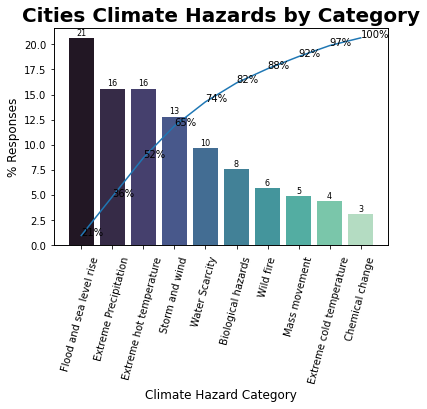

In [49]:
df = get_response_pivot(data=cir, questionnumber="2.1", columnnumber=["1", "2"], pivot=False)

# select rows and get responses from dataframe
data = df.query('column_number == 1')
answers = data.response_answer.apply(lambda x: x.split(">")[0])     # get responses from data frame

# provide corrosponding question context
print_question(data, "2.1",[1]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
                      
# Configure main plot
plt.figure(figsize=(8,6))
ax = plot_pareto(data=perc, xlabel="Climate Hazard Category", ylabel="% Responses",
                        title="Cities Climate Hazards by Category", orient="v")

rotate_labels(fig=ax, axis="x", rotation=75)
add_patches(ax);
val

Examining the 10 categories, we see that more than 20% of the cities are afraid of flood and sea level rise, extreme precipitation and hot temperatures are also mentioned abore average. 
Of particular importance are the threats posed by extremely high temperatures, water scarcity and mass movement. It can be assumed that socially disadvantaged groups and poorer countries in particular are affected by these effects much more strongly and frequently than the world's strong industrialised nations.

Q2.1:'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
2: 'Did this hazard significantly impact your city before 2019?'
 'Did this hazard significantly impact your city before 2020?'
Number responses:5270


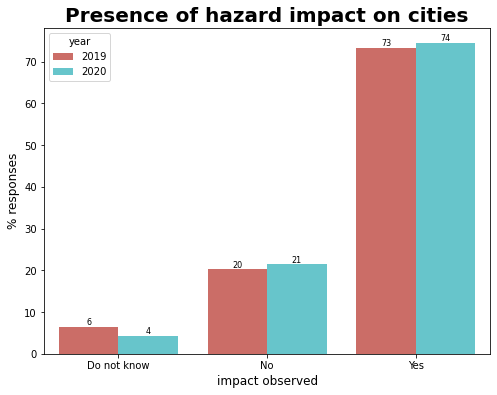

In [50]:
# select rows and get responses from dataframe
data = df.query('column_number == 2')
answers = data.response_answer     # get responses from data frame

gob = data.groupby(["year","response_answer"]).count()
gob = gob.iloc[:,0]
gob_perc = gob.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
gob_perc = round(gob_perc, 1)
gob_perc = gob_perc.reset_index()

# provide corrosponding question context
print_question(data, "2.1",[2]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
                      

# Configure main plot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=gob_perc, x="response_answer", y="account_number",hue = "year", orient="v", palette="hls") #xlabel="Frequency", ylabel="Climate Hazard",
                      #  title="Cities threatining Climate Hazards", orient="h", ax=ax_b1)
ax.set_xlabel("impact observed",fontdict={"fontsize":rcParams["axes.labelsize"]})
ax.set_ylabel("% responses", fontdict={"fontsize":rcParams["axes.labelsize"]})
ax.set_title("Presence of hazard impact on cities", fontdict={"fontsize":rcParams["axes.titlesize"], "fontweight":rcParams["axes.titleweight"]})
add_patches(ax);
print("Number responses:" + str(len(data)));

This observation shows very clearly that a concrete threat to cities has long been a reality. Of the more than 5,000 hazards mentioned, 74% can no longer be considered as a theoretical risk, but have already had a concrete negative effect on the city.

### Corporates 

QC2.3:'Have you identified any inherent climate-related risks with the potential to have a substantive financial or strategic impact on your business?'
------------------------------------------------------------------------------------------
0: 'C2.3'
QC2.3:'Have you identified any inherent climate-related risks with the potential to have a substantive financial or strategic impact on your business?'
------------------------------------------------------------------------------------------
0: 'C2.3'


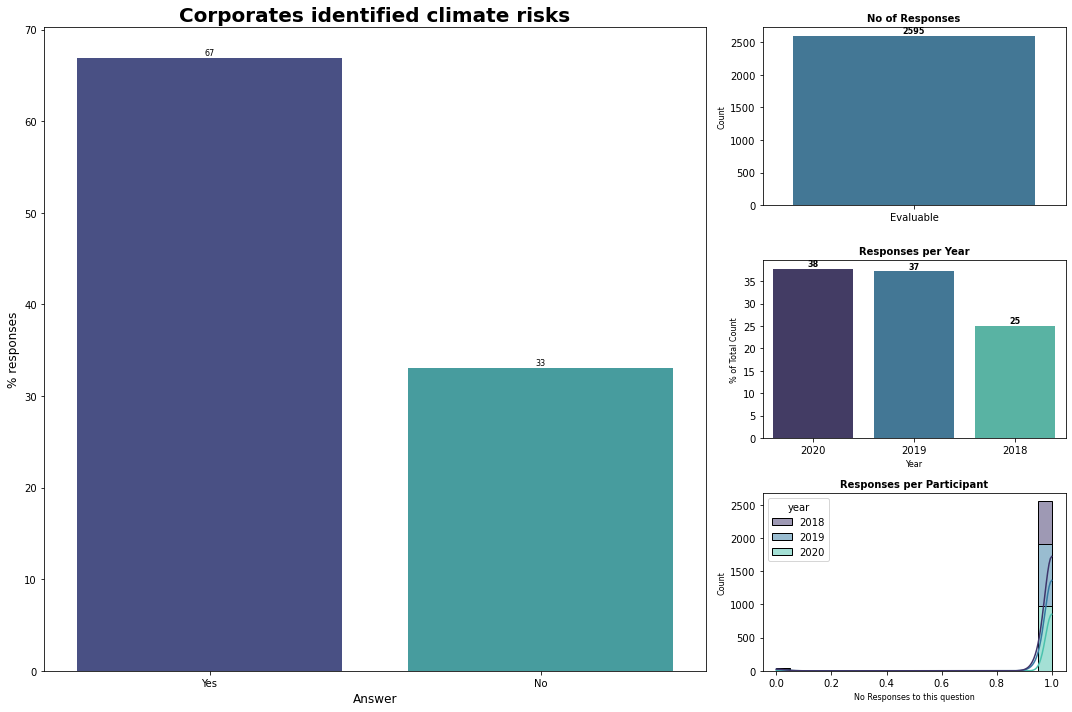

Number responses:2595


In [51]:
df = get_response_pivot(data=cor, questionnumber="C2.3", pivot=False)

# select rows and get responses from dataframe
data = df
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "C2.3", [0]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
                      
# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(15,10), orient="vertical")

# Configure main plot
ax_b1 = plot_freq_of_cv(data=perc, xlabel="Answer", ylabel="% responses",
                        title="Corporates identified climate risks", orient="v", ax=ax_b1)


add_patches(ax_b1)
# Calculate basic plots
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)

plt.tight_layout();
plt.show();

print("Number responses:" + str(len(data)));

In more than 2,500 surveys (between 2018 and 2020), 67% of companies stated that they had identified climate-related risks with substantial financial or strategic influence. From this we can conclude that companies also feel threatened and are likely to show willingness to change and cooperate.

QC2.3a:'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
3: 
4: 
QC2.3a:'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
3: 'C2.3a_c3-Risk type'


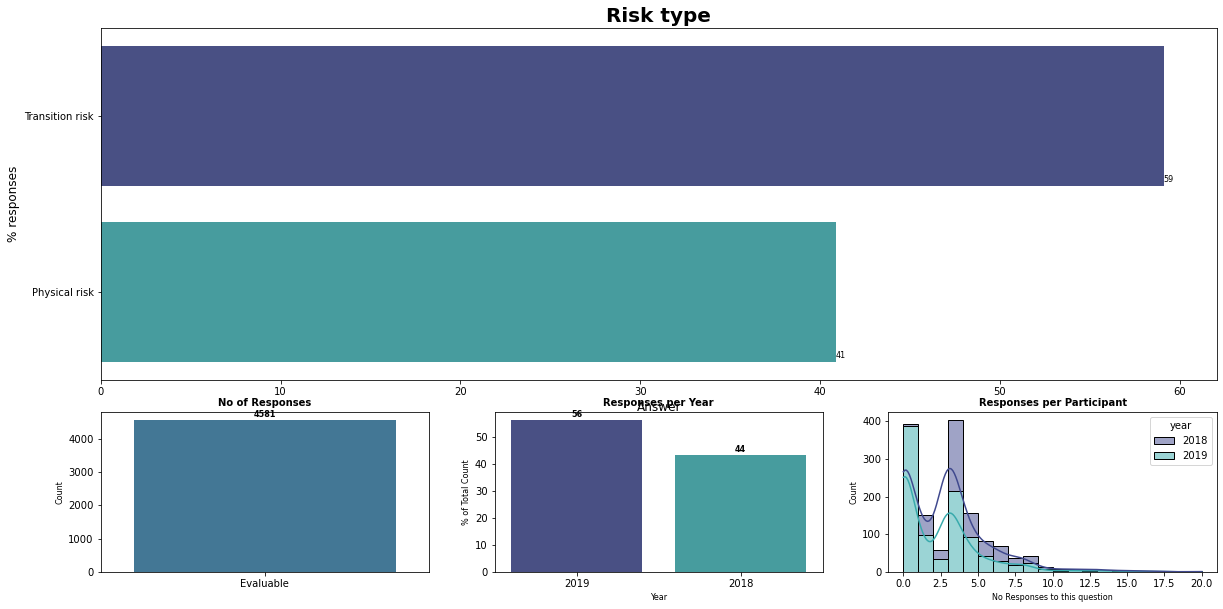

<Figure size 576x432 with 0 Axes>

Number responses:4581
Answers reflected by plot: 100.0%


In [52]:
df = get_response_pivot(data=cor, questionnumber="C2.3a", columnnumber=["3", "4"], pivot=False)

# select rows and get responses from dataframe
data = df.query("column_number == 3 & column_name == 'C2.3a_c3-Risk type'")
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "C2.3a", [3]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
top = perc.nlargest(20)

                      
# Create plotting grid
fig, ax_b1, ax_s1, ax_s2, ax_s3 = create_3x3grid(size=(20,10), orient="horizontal")

# Configure main plot
plt.figure(figsize=(8,6))
ax_b1 = plot_freq_of_cv(data=top, xlabel="Answer", ylabel="% responses",
                        title="Risk type", orient="h", ax=ax_b1)

add_patches(ax_b1, "h")

# Calculate basic plots
ax_s1 = plot_small_no_responses(data, ax=ax_s1)
ax_s2 = plot_small_responses_yoy(data, ax=ax_s2, plt_type="perc");
ax_s3 = plot_small_responses_per_ptcp(data, ax=ax_s3)

plt.tight_layout();
plt.show();
print("Number responses:" + str(len(data)))
print("Answers reflected by plot: "+str(top.sum())+"%");

59 % of the corporates risks are related to the effects of big econimical shifts, while 41 % refer to actual physical damage. We'll explore the meaning of these categories further below.

QC2.3a:'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
3: 'C2.3a_c3-Risk type & Primary climate-related risk driver_G'


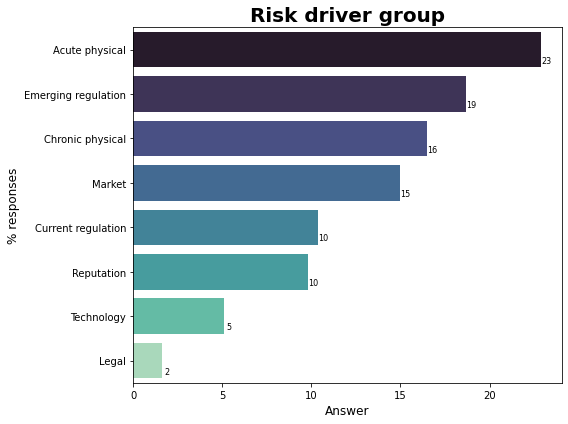

Number responses:2744
Answers reflected by plot: 100.0%


In [53]:
# select rows and get responses from dataframe
data = df.query("column_number == 3 & column_name == 'C2.3a_c3-Risk type & Primary climate-related risk driver_G'")
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "C2.3a", [3]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
top = perc.nlargest(20)

                      


# Configure main plot
plt.figure(figsize=(8,6))
ax_b1 = plot_freq_of_cv(data=top, xlabel="Answer", ylabel="% responses",
                        title="Risk driver group", orient="h")
add_patches(ax_b1, "h")

plt.tight_layout();
plt.show();
print("Number responses:" + str(len(data)))
print("Answers reflected by plot: "+str(top.sum())+"%");

Four pillars characterise the risk profile of companies:

* **Physical damage**  
* **emerging regulation**  
* **Market risks**
* **Technology**

While cities and companies paint a similar picture in terms of concerns about physical damage and unfavourable technological development, companies' concerns about regulation and market changes partly conflict with the objectives of socially responsible climate protection.


QC2.3a:'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
3: 'C2.3a_c3-Risk type & Primary climate-related risk driver'


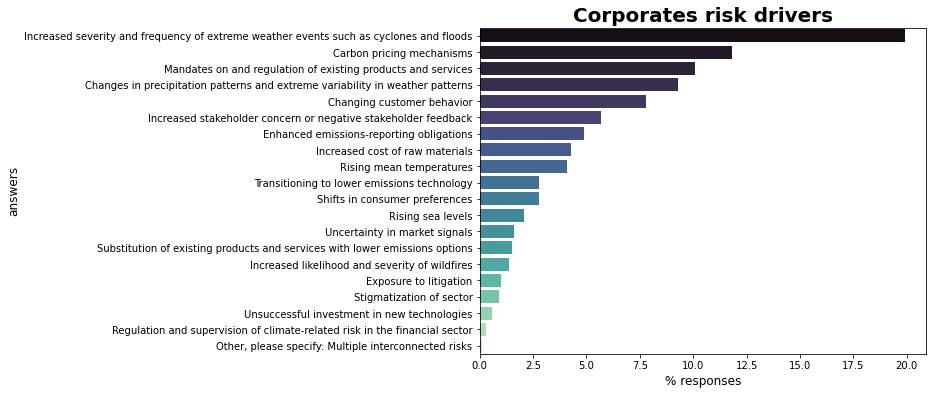

Number responses:2744
Answers reflected by plot: 92.99999999999999%


In [54]:
# select rows and get responses from dataframe
data = df.query("column_number == 3 & column_name == 'C2.3a_c3-Risk type & Primary climate-related risk driver'")
answers = data.response_answer     # get responses from data frame

# provide corrosponding question context
print_question(data, "C2.3a", [3]) 

# preprocess / calculate data for visualization
val, perc = get_pct_freq(answers)
top = perc.nlargest(20)


# Configure main plot
plt.figure(figsize=(8,6))
ax_b1 = plot_freq_of_cv(data=top, xlabel="% responses", ylabel="answers",
                        title="Corporates risk drivers", orient="h")



plt.show();
print("Number responses:" + str(len(data)))
print("Answers reflected by plot: "+str(top.sum())+"%");

Focusing on the top 20 responses (reflecting 93% of al answers to this question) it shows up clearly that companies are most afraid of the effect of **extreme weather events**, just like the cities. They are also afraid of new climate-related **regulatory mechanisms**, including those relating to carbon emissions. While this view of the companies opposes collaborative behaviour, other aspects are likely to encourage it:
As many companies fear climate-related changes in consumer behaviour, close cooperation with external stakeholders will become increasingly important for the success of companies in the future.

### Scoring

In order to classify the risk perspective of cities and companies in a relatively comparable way, we transfer the answers to selected survey questions into a risk scoring. The general idea of the score methodology can be interpreted as follows:

- 1: entity is not threatened by climate related hazards
- 2: entity is only slightly affected by climate related hazards
- 3: entity is affected on average by climate related hazards
- 4: entity is disproportionately affected by climate related hazards
- 5: entity is strongly threatend by climate related hazards

- 0/NaN: entity provides not enough utilizable data for scoring

Due to the great heterogeneity of the questions and answers, the specific scoring components deviate slightly from this basic logic with regard to the concrete individual questions.

In the following section we will look on these scoring criteria more specifically.


In [55]:
# creating initial dataframe for city and corporate scores:
cis = pd.DataFrame(columns=["account_number", "year"]) #city scores
cos = pd.DataFrame(columns=["account_number", "year"]) #corporate scores

# create dataframe with score explanation
sex = pd.DataFrame(columns=["type", "score_name", "score_question", "score_explanation"])

#### Cities

**r_score_1:**
Number of climate hazards

The number of identified climate hazards of can be taken as a first indicator of the current risk label. Therefor we divide the counts of the cities hazards into 5 scoring bins with the following properties:
- 1: less than 2 hazards
- 2: less than 5 hazards
- 3: less than 8 hazards
- 4: less than 15 hazards
- 5: more than 15 hazards
The bin number matches the score value.

**r_score_2:**
climate hazards with significant impact

The methodoly for r_score_2 follows exactly the r_score_1 scheme. As we are talking about hazards that already have an impact on the city, we set the bin threshold much lower:
- 1: less than 1 hazards
- 2: less than 2 hazards
- 3: less than 4 hazards
- 4: less than 7 hazards
- 5: more than 7 hazards
The bin number matches the score value.

**r_score_3** <br/>
climate hazards current probability

To transform the current probability into a numeric score we first of all translate the responses into corrosponding calculation scores for every single risk:
    "Does not currently impact the city": 1,
    "Low": 1,
    "Medium Low": 2,
    "Medium": 3,
    "Medium High": 4,
    "High": 5
    
The overall score calulcation per entity follows these values and calculates the mean risk probability. To receive the final score per entitiy, the means are grouped into 5 quintiles, representing the lowest 20% up to the highest 20% average per entity:
- 1: average risk propability for the entity belongs to the lowest 20% of all entities
<br/>..
- 5: average risk propability for the entity belongs to the highest 20% of all entities


**r_score_4** <br/>
climate hazards current magnitude

The calculation of the magnitude scores follows exactly the methodoly for r_score_3 (see above)

In [56]:
### r_score_1 ###

df = cir.copy()
e_type = "cis"
score = "r_score_1"
base_question = "2.1"
base_column = 1

# select rows and get responses from dataframe
data = df.query('question_number == @base_question & column_number == @base_column')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)["response_answer"].count()
gob[score] = (pd.cut(gob.response_answer, bins=[0, 2, 5, 8, 15, 99], labels=[1, 2, 3, 4, 5])).astype(int)
gob = gob.loc[:,["account_number", "year", score]]

# # add score to dataframe
cis = pd.merge(left=cis, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                        "1: less than 2 two hazards, 2: less than 5, 3: less than 8, 4: less than 15, 5: more than 15 hazards"],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)


### r_score_2 ###

df = cir.copy()
e_type = "cis"
score = "r_score_2"
base_question = "2.1"
base_column = 2

# select rows and get responses from dataframe
data = df.query('question_number == @base_question & column_number == @base_column & response_answer == "Yes"')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)["response_answer"].count()
gob[score] = (pd.cut(gob.response_answer, bins=[0, 1, 2, 4, 7, 99], labels=[1, 2, 3, 4, 5])).astype(int)
gob = gob.loc[:,["account_number", "year", score]]

# # add score to dataframe
cis = pd.merge(left=cis, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                        "1: less than 1 two hazards, 2: less than 2, 3: less than 4, 4: less than 7, 5: more than 7 hazards"],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)


### r_score_3 ###

df = cir.copy()
e_type = "cis"
score = "r_score_3"
base_question = "2.1"
base_column = 3

# select rows and get responses from dataframe
data = df.copy().query('question_number == @base_question & column_number == @base_column & response_answer !="Do not know"')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# map text responses to values
response_map = {
    "Does not currently impact the city": 1,
    "Low": 1,
    "Medium Low": 2,
    "Medium": 3,
    "Medium High": 4,
    "High": 5
               }

data["calc_column"] = data.response_answer.map(response_map)

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)["calc_column"].mean()
gob[score] = (pd.cut(gob.calc_column, bins=5, labels=[1, 2, 3, 4, 5])).astype(int)
gob = gob.loc[:,["account_number", "year", score]]

# # add score to dataframe
cis = pd.merge(left=cis, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                        """mapped values for every single risk from 1 to 5 and calculated avg. 
                        risk propability per entity. 1: propability for the entity belongs to 
                        the lowest 20% of all entities...
                        5: belongs to highest 20%"""
                            ],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)

### r_score_4 ###

df = cir.copy()
e_type = "cis"
score = "r_score_4"
base_question = "2.1"
base_column = 4

# select rows and get responses from dataframe
data = df.copy().query('question_number == @base_question & column_number == @base_column & response_answer !="Do not know"')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# map text responses to values
response_map = {
    "Does not currently impact the city": 1,
    "Low": 1,
    "Medium Low": 2,
    "Medium": 3,
    "Medium High": 4,
    "High": 5
               }

data["calc_column"] = data.response_answer.map(response_map)

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)["calc_column"].mean()
gob[score] = (pd.cut(gob.calc_column, bins=5, labels=[1, 2, 3, 4, 5])).astype(int)
gob = gob.loc[:,["account_number", "year", score]]

# # add score to dataframe
cis = pd.merge(left=cis, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                        """mapped values for every single risk from 1 to 5 and calculated avg. 
                        risk magnitude per entity. 1: magnitude for the entity belongs to 
                        the lowest 20% of all entities...
                        5: belongs to highest 20%"""
                            ],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)

Q2.1:'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
1: 'Climate Hazards'
Q2.1:'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'
------------------------------------------------------------------------------------------
2: 'Did this hazard significantly impact your city before 2019?'
 'Did this hazard significantly impact your city b

#### Corporates

**r_score_1**<br/>
Inherent climate related risk

As the scoring is based on a boolean-structured questions, we simply mapped the answers Yes and No to score values:
- 1: No, no inherent risk identified
- 5: Yes, inherent risk identified


**r_score_2**<br/>
Risk Type

Based on every single identified risk position of a company, we assigned scoring values to the responses. The main factor for the single score is physical threat a risk provides. Therefor physical threats score high, while e.g. regulational threads score low:  

* 1 = 'Emerging regulation'
* 1 = 'Reputation'
* 1 = 'Market'
* 1 = 'Legal'
* 2 = 'Current regulation'
* 3 = 'Technology
* 4 = 'Chronic physical'
* 5 = 'Acute physical'

    
The overall score calulcation per entity follows these values and calculates the mean risk scoring. To receive the final score per entitiy, the means are grouped into 5 quintiles, representing the lowest 20% up to the highest 20% average per entity:

1: average risk score for the entity belongs to the lowest 20% of all entities
..
5: average risk score for the entity belongs to the highest 20% of all entities


**r_score_3**<br/>
Transitional / physical risks

As stated before physical risks are of higher importance the transitional risks. Therefor we assigned the following score-values:

*  0: transitional risk
*  1: physical risk

After weighting all the entries we build the average for entity / year and group the means into 5 quintiles, representing the lowest 20% up to the highest 20% average per entity:

1: physical risk component for the entity belongs to the lowest 20% of all entities <br/>
.. 
5: physical risk component for the entity belongs to the highest 20% of all entities

In [57]:
### r_score_1

df = cor.copy()
e_type = "cos"
score = "r_score_1"
base_question = "C2.3"
base_column = 0

# select rows and get responses from dataframe
data = df.copy().query('question_number == @base_question & column_number == @base_column')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# map text responses to values
response_map = {"No": 1, "Yes" : 5}

data[score] = data.response_answer.map(response_map)

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)[score].sum()
gob = gob.loc[:,["account_number", "year", score]]

# add score to dataframe
cos = pd.merge(left=cos, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                        "1: no inherent risk, 5: inherent risk identified"],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)

### r_score_2 ###

df = cor.copy()
e_type = "cos"
score = "r_score_2"
base_question = "C2.3a"
base_column = 3

# select rows and get responses from dataframe
data = df.copy().query('question_number == @base_question & column_number == @base_column & column_name == "C2.3a_c3-Risk type & Primary climate-related risk driver_G"')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# map text responses to values
response_map = {
    'Emerging regulation' : 1, 
    'Reputation' :1, 
    'Acute physical' : 5,
    'Technology': 3, 
    'Market' : 1, 
    'Chronic physical' : 4, 
    'Current regulation' : 2,
    'Legal':1
    }

data["calc_column"] = data.response_answer.map(response_map)

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)["calc_column"].mean()
gob[score] = (pd.cut(gob.calc_column, bins=5, labels=[1, 2, 3, 4, 5])).astype(float)
gob = gob.loc[:,["account_number", "year", score]]

# add score to dataframe
cos = pd.merge(left=cos, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                        """mapped values for every single risk from 1 to 5 and calculated avg. 
                        risk propability per entity. 1: propability for the entity belongs to 
                        the lowest 20% of all entities...
                        5: belongs to highest 20%"""
                            ],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)


### r_score_3 ###

df = cor.copy()
e_type = "cos"
score = "r_score_3"
base_question = "C2.3a"
base_column = 3

# select rows and get responses from dataframe
data = df.copy().query('question_number == @base_question & column_number == @base_column & column_name == "C2.3a_c3-Risk type"')

# provide corrosponding question context
q_string = print_question(data, base_question, [base_column]) 

# map text responses to values
response_map = {"Transition risk": 0, "Physical risk" : 1}

data["calc_column"] = data.response_answer.map(response_map)

# calculate scoring
gob = data.groupby(["account_number", "year"], as_index=False)["calc_column"].mean()
gob[score] = (pd.cut(gob.calc_column, bins=5, labels=[1, 2, 3, 4, 5]))
gob = gob.loc[:,["account_number", "year", score]]

# add score to dataframe
cos = pd.merge(left=cos, right=gob, on=["account_number", "year"], how="outer")

# add explanation to dataframe
question = pd.Series(data=[
                        e_type, 
                        score, 
                        q_string,
                         """mapped values {"Transition risk": 0, "Physical risk" : 1} 
                         for every single risk and calculated avg. The closer to 1 the higher the risk.
                         Split risk-avg into 5 bins, representing 20% slices of all values.
                        1: physical risk for the entity belongs to 
                        the lowest 20% of all entities...
                        5: belongs to highest 20%"""],
                    index=sex.columns)
sex = sex.append(question, ignore_index=True)




QC2.3:'Have you identified any inherent climate-related risks with the potential to have a substantive financial or strategic impact on your business?'
------------------------------------------------------------------------------------------
0: 'C2.3'
QC2.3a:'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
3: 'C2.3a_c3-Risk type & Primary climate-related risk driver_G'
QC2.3a:'Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business.'
------------------------------------------------------------------------------------------
3: 'C2.3a_c3-Risk type'


## Engagement
<br/>

**Exploration Content**:<br/>
At this point, we look at various questions that provide information on the extent to which cities and companies are addressing the issue of sustainability in terms of both quality and quantity. In other words, we determine the extent of their commitment to environmental protection. As part of the engagement exploration we look at whether the participants have **publicly commited** to a reduction target, and whether they have commited to the **Paris Climate Agreement** objectives. As the scoring is fairly extensive in this section, we will only highlight a few scores. The full list of engagement scores can be found in our **dashboard**


**Motivation Purpose**:<br/>
We want to create a scoring base on the basis of which we can use the dashboard evaluations to find out whether there are significant regional or industry-specific differences (deficits/development potential) and show their dependence on the other parameters. 


### Scoring

**The scoring methodology here is as follows:**
* 0: no response (nan)
* 1: 0 Targets
* 2: 1 or 2 targets
* 3: 3 or 4 targets
* 4: 5 or 6 targets
* 5: 7 or more targets
    
    
**The scoring methodology here is as follows:**
* 0: no response (nan)
* 1: No / Not intending to undertake / Do not know
* 2: Intending to undertake in future
* 3: Intending to undertake in the next 2 years
* 4: In progress
* 5: Yes
    
    
    **The scoring methodology here is as follows:**
* 0: no response (nan)
* 1: Total estimated annual CO2e savings in metric tonnes CO2e for implemented initiatives: =      0
* 2: Total estimated annual CO2e savings in metric tonnes CO2e for implemented initiatives: >      0
* 3: Total estimated annual CO2e savings in metric tonnes CO2e for implemented initiatives: >=   800
* 4: Total estimated annual CO2e savings in metric tonnes CO2e for implemented initiatives: >=  6000
* 5: Total estimated annual CO2e savings in metric tonnes CO2e for implemented initiatives: >= 42000

        
**The scoring methodology here is as follows:**
* 0: no response (nan)
* 1: Do not know
* 1: No
* 2: Other: Aligned with Kyoto Protocol targets and Provincial targets
* 2: Other: In order to be aligned with the Paris agreement an acceleration is needed. As a matter of fact Milan already signed the Covenant of Mayors for Climate and Energy and the Deadline 2020
* 2: Other: It has 40% by 2030, but by 2005 year not 1990 as the baseline.
* 2: Other: Target is old, will be revised in 2019
* 3: Other
* 3: Other: Current CAP does not; new targets for 2030 and 2050 will align with Paris Agreement
* 3: Other: It is not of competence of the city to assess this. It actually depends on the contributions by all local and national authorities in total.
* 3: Other: Target year is too early for Paris Agreement, but may be considered to be aligned.
* 4: Other: Boston's 2050 target (carbon neutrality) aligns with the global 1.5 - 2 °C pathway set out in the Paris Agreement.
* 4: Other: Yes
* 4: Yes - 2 °C
* 5: Other: Carbon Neutrality by 2045 goes beyond the emissions reduction pathway to 1.5 degrees.
* 5: Other: Yes - 1 degree C
* 5: Yes - 1.5 °C     


## Emissions 

In this section we'll have a closer look to the emission data provided by the cities and corporations answers. And we'll have a look at the distribution of the emission between the others in the same region for cities and between the others in the same industry for corporations.

We'll use this data then to build scores, to rank the cities and corporations based on their emission data.

### Emission data compared to other areas

In [58]:
# Import emission data and remove unnecessary columns

answer_4_6a = pd.read_csv('data/Cities/cid_total_emissions_v2.csv')
answer_4_6a = answer_4_6a.iloc[:,3:6]

# Merge population data from cid dataframe

cid_red = cid.drop_duplicates(subset='account_number', keep='first')

answer_4_6a   = pd.merge(left = answer_4_6a,
                     right = cid_red[['region', 'population']],
                     left_on = answer_4_6a['account_number'],
                     right_on = cid_red['account_number'], 
                     how = 'left')

# Calculate emission per population in new column

answer_4_6a['emission_per_pop'] = answer_4_6a['total_emissions']/answer_4_6a['population']

### How many cities participated
In the regions South and West Asia, as in Middle East only a few cities provided their emission data. Therefore it is not sufficient data in some cases, to make conclusions out of it.

In [59]:
answer_4_6a.region.value_counts()

Latin America                 660
North America                 564
Europe                        483
Africa                        126
Southeast Asia and Oceania    124
East Asia                      69
South and West Asia            25
Middle East                    17
Name: region, dtype: int64

### Median emission per region
In the following section, we compare the median emission per cities between the regions. These plots are part of the EDA, but the plots are not meaningful due to unsuffisient data. In the end the values are not compareable. So there is no interpretation.

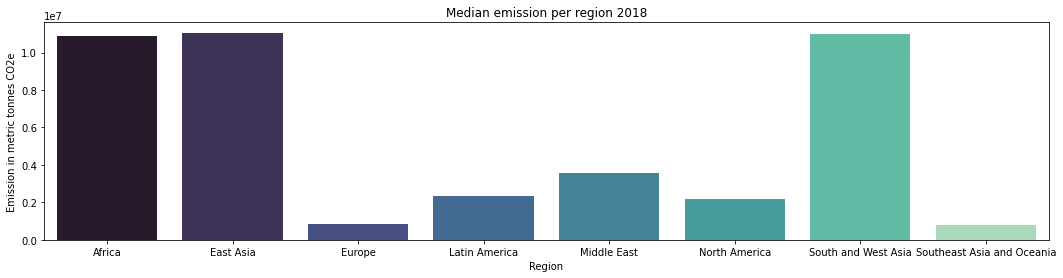

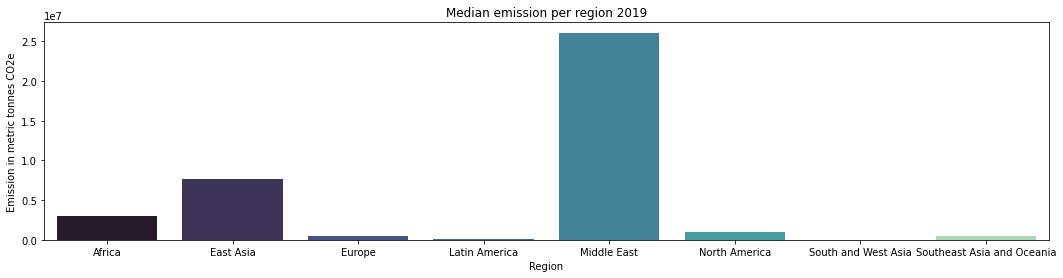

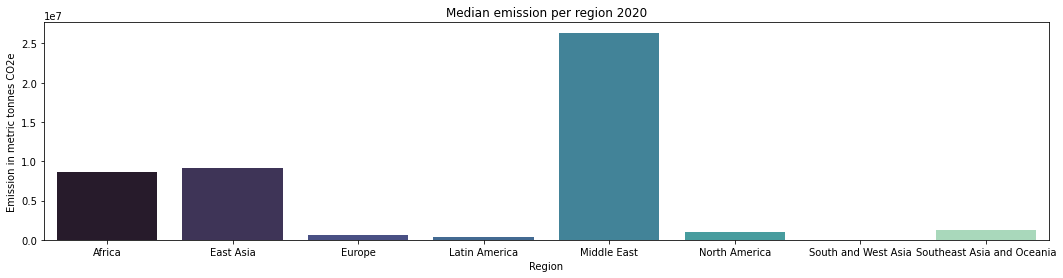

In [60]:
df = answer_4_6a[answer_4_6a['year'] == 2018].groupby('region').median()
df.reset_index(inplace=True)
plt.figure(figsize=(18, 4))
#fig.set_axis_labels('Region', 'Emission')
ax = sns.barplot(x='region', y='total_emissions', data=df, palette='mako');
ax.set(xlabel='Region', ylabel='Emission in metric tonnes CO2e', title='Median emission per region 2018');

df = answer_4_6a[answer_4_6a['year'] == 2019].groupby('region').median()
df.reset_index(inplace=True)
plt.figure(figsize=(18, 4))
#fig.set_axis_labels('Region', 'Emission')
ax = sns.barplot(x='region', y='total_emissions', data=df, palette='mako');
ax.set(xlabel='Region', ylabel='Emission in metric tonnes CO2e', title='Median emission per region 2019');

df = answer_4_6a[answer_4_6a['year'] == 2020].groupby('region').median()
df.reset_index(inplace=True)
plt.figure(figsize=(18, 4))
#fig.set_axis_labels('Region', 'Emission')
ax = sns.barplot(x='region', y='total_emissions', data=df, palette='mako');
ax.set(xlabel='Region', ylabel='Emission in metric tonnes CO2e', title='Median emission per region 2020');

### Median emission per population

In the following section, we compare the median emission per population per cities between the regions. These plots are part of the EDA, but the plots are not meaningful due to unsuffisient data. In the end the values are not compareable. So there is no interpretation.

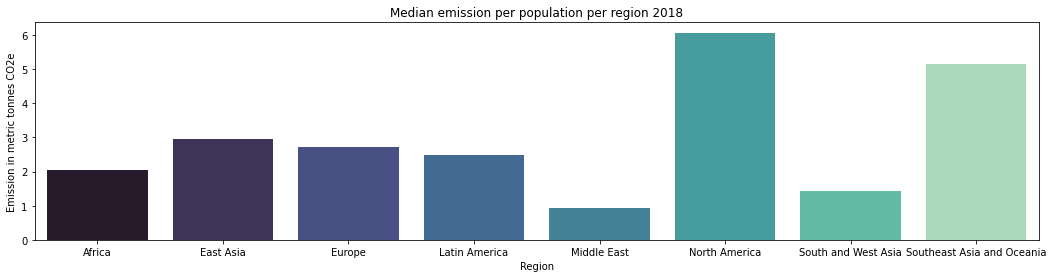

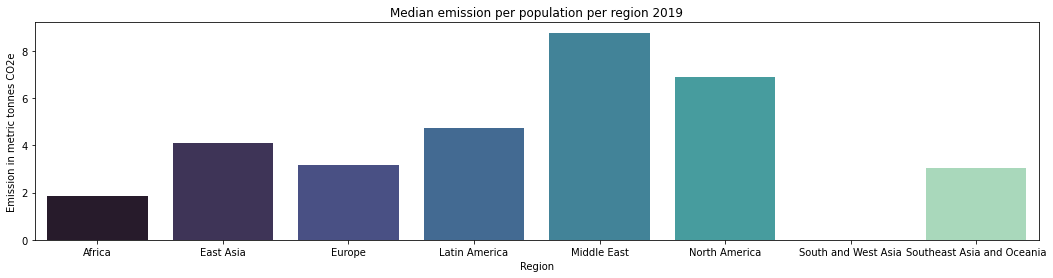

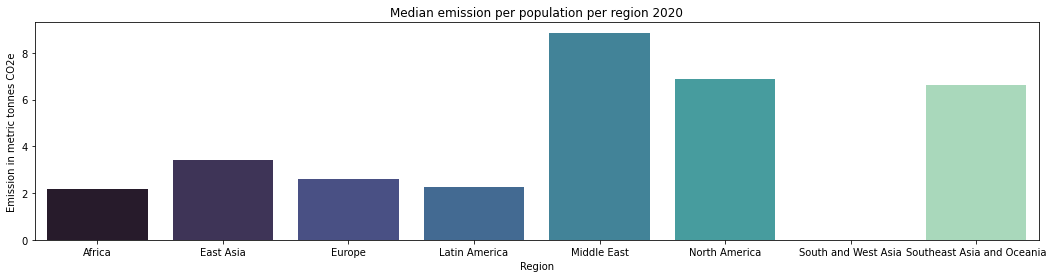

In [61]:
df = answer_4_6a[answer_4_6a['year'] == 2018].groupby('region').median()
df.reset_index(inplace=True)
plt.figure(figsize=(18, 4))
#fig.set_axis_labels('Region', 'Emission')
ax = sns.barplot(x='region', y='emission_per_pop', data=df, palette='mako');
ax.set(xlabel='Region', ylabel='Emission in metric tonnes CO2e', title='Median emission per population per region 2018');

df = answer_4_6a[answer_4_6a['year'] == 2019].groupby('region').median()
df.reset_index(inplace=True)
plt.figure(figsize=(18,4))
#fig.set_axis_labels('Region', 'Emission')
ax = sns.barplot(x='region', y='emission_per_pop', data=df, palette='mako');
ax.set(xlabel='Region', ylabel='Emission in metric tonnes CO2e', title='Median emission per population per region 2019');

df = answer_4_6a[answer_4_6a['year'] == 2020].groupby('region').median()
df.reset_index(inplace=True)
plt.figure(figsize=(18, 4))
#fig.set_axis_labels('Region', 'Emission')
ax = sns.barplot(x='region', y='emission_per_pop', data=df, palette='mako');
ax.set(xlabel='Region', ylabel='Emission in metric tonnes CO2e', title='Median emission per population per region 2020');

###  Scoring

For **cities**, there will be two scores for the emission data. 

**em_score_1** will give a score for the actual emission per people and year that are situated in the respective city. 5 points means, that there is less than 3 tonnes of emission per year and person. This is the mean value of emission per people and year in the world before 1960. Actual studies use this value as a safe value for preventing the climate change keeping in mind, that the population in the world already raised up in the meantime.

**em_score_2** will give a score for aimed emission per people and year one year in advance. It is calculated based on the provided data. If data is missing for calculating this score, it won't be calculated.

- 5 Points for less than  3    tonnes of emission per person and year
- 4 Points for less than  3.75 tonnes of emission per person and year
- 3 Points for less than  5    tonnes of emission per person and year
- 2 Points for less than  7.5  tonnes of emission per person and year
- 1 Point  for less than  15   tonnes of emission per person and year

- 0 Points for missing answers

In [62]:
# Creating em_scores

# Creating scoring function for em_score_1 and em_score_2
def create_score(x):

    if 0 < x < 3:
        return 5
    elif 0 < x < 3.75:
        return 4
    elif 0 < x < 5:
        return 3
    elif 0 < x < 7.5:
        return 2
    elif 0 < x:
        return 1
    else:
        return 0


# Collecting relevant answers for em_score_1 and em_score_2
# Reading information from csv_file with relevant answers and merge it with relevant information from cid dataframe
reduced = pd.read_csv('data/Cities/cid_em_answers.csv')
cid_red = cid.drop_duplicates(subset='account_number', keep='first')

reduced = pd.merge(left=reduced,
                   right=cid_red[['region', 'population']],
                   left_on=reduced['account_number'],
                   right_on=cid_red['account_number'],
                   how='left')

# Creating key based on year and account number
reduced["select_key"] = reduced["year"].astype(
    str)+"_"+reduced["account_number"].astype(str)

# Calculating target emission per people and year one year in advance
reduced['next_emission_pop'] = (((reduced['50a_target_year_emissions'] - reduced['total_emissions']) / (
    reduced['50a_target_year'] - reduced['year'])) + reduced['total_emissions']) / reduced['population']

# Calculating actual emission per people and year
reduced['emission_pop'] = reduced['total_emissions'] / reduced['population']

# Colleting results in dataframe
reduced = reduced[['emission_pop', 'next_emission_pop', 'select_key']]
em_score = pd.DataFrame()
em_score['select_key'] = reduced['select_key']
em_score['em_score_1'] = reduced.emission_pop.apply(create_score)
em_score['em_score_2'] = reduced.next_emission_pop.apply(create_score)




For **corporates**, we will assign for emission data.  

**em_score_1** will give a score for the actual scope 1 emission in comprehension to the other scope 1 emissions in the other corporations being in the same industry.  

- 5 Points for being in the first quantile of scope 1 emissions
- 4 Points for being in the second quantile of scope 1 emissions
- 3 Points for being in the third quantile of scope 1 emissions
- 2 Points for being in the fourth quantile of scope 1 emissions
- 1 Point for being in the fifth quantile of scope 1 emissions
- 0 Points for missing answers


**em_score_2** will give a score for providing emission data for scope 1, 2 and 3.  
- 5 Points for providing scope 3 emission data and scope 1 or 2
- 4 Points for providing only scope 3 emission data
- 3 Points for providing only scope 1 and 2 data
- 2 Points for providing only scope 2 data
- 1 Point for providing only scope 1 data
- 0 Points for missing answers


**Idea for a more distributed em_score_2 (needs testing)** 
- 5 Points for providing all 3 scopes
- 4 Points for providing scope 1 and scope 2
- 3 Points for providing scope 2 and scope 3
- 2 Points for providing only scope 1
- 2 Points for providing only scope 2
- 2 Points for providing only scope 3
- 1 Point for providing nothing
- 0 Points for missing answers

In [63]:
# Creating dataframe subset for question C6.1 column 1
reduced = cor[(cor['question_number'] == 'C6.1') & (
    cor['theme'] == 'climate') & (cor['column_number'] == 1)]
reduced["select_key"] = reduced["year"].astype(
    str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

# Remark: Column 1 contains multiple entries for 'Reporting year', 'Past year 1', 'Past year 2', 'Past year 3'
# Hence, there are more responses than Account/Year

# Count for companies with several answers the highest value
reduced["response_answer"] = reduced.response_answer.astype(float)
reduced = reduced.groupby('select_key')['response_answer'].max().to_frame()
reduced['select_key'] = reduced.index
reduced = reduced[['select_key', 'response_answer']]
reduced_em1 = pd.DataFrame()
reduced_em1['select_key'] = reduced['select_key']
reduced_em1['total_emissions'] = reduced['response_answer']
reduced_em1.reset_index(drop=True, inplace=True)

# Merge data together with data from cod dataframe
cod_red = cod[cod['theme'] == 'climate']
cod_red["select_key"] = cod_red["year"].astype(
    str)+"_"+cod_red["account_number"].astype(str)
cod_red.reset_index(inplace=True)
cod_em1 = pd.merge(left=cod_red,
                   right=reduced_em1[['total_emissions']],
                   left_on=cod_red['select_key'],
                   right_on=reduced_em1['select_key'],
                   how='left',
                   copy=False)
cod_em1['total_emissions'] = cod_em1['total_emissions'].astype("float")

# Create dataframe with quantiles of total emission grouped by industries
q = pd.DataFrame()
q['a'] = cod_em1.groupby('industries')['total_emissions'].quantile(
    0.2).to_frame()['total_emissions']
q['b'] = cod_em1.groupby('industries')['total_emissions'].quantile(
    0.4).to_frame()['total_emissions']
q['c'] = cod_em1.groupby('industries')['total_emissions'].quantile(
    0.6).to_frame()['total_emissions']
q['d'] = cod_em1.groupby('industries')['total_emissions'].quantile(
    0.8).to_frame()['total_emissions']
q['industries'] = q.index
q.reset_index(drop=True, inplace=True)

# Merge generated information back to dataframe
cod_em1 = cod_em1.iloc[:, 1:]
cod_em1 = pd.merge(left=cod_em1,
                   right=q[['a', 'b', 'c', 'd']],
                   left_on=cod_red['industries'],
                   right_on=q['industries'],
                   how='left')

# Create scoring function for em_score_1


def score(c):

    if c['total_emissions'] < c['a']:
        return 5
    elif (c['total_emissions'] > c['a']) & (c['total_emissions'] < c['b']):
        return 4
    elif (c['total_emissions'] > c['b']) & (c['total_emissions'] < c['c']):
        return 3
    elif (c['total_emissions'] > c['c']) & (c['total_emissions'] < c['d']):
        return 2
    elif (c['total_emissions'] > c['d']):
        return 1
    else:
        return 0


# Create em_score_1
cod_em1['em_score_1'] = cod_em1.apply(score, axis=1)
cod_em1 = cod_em1[['select_key', 'em_score_1']]

####  SCOPE 1 EMISSION SCORE ####

# Creating dataframe subset for question C6.1 column 1
reduced = cor[(cor['question_number'] == 'C6.1') & (
    cor['theme'] == 'climate') & (cor['column_number'] == 1)]
reduced["select_key"] = reduced["year"].astype(
    str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

# Create dataframe with scope 1 emissions
reduced["response_answer"] = reduced.response_answer.astype(float)
reduced = reduced.groupby('select_key')['response_answer'].max().to_frame()
reduced['select_key'] = reduced.index
reduced = reduced[['select_key', 'response_answer']]
reduced_sc1 = pd.DataFrame()
reduced_sc1['select_key'] = reduced['select_key']
reduced_sc1['scope_1'] = reduced['response_answer']
reduced_sc1.reset_index(drop=True, inplace=True)

####  SCOPE 2 EMISSION SCORE ####

# Creating dataframe subset for question C6.3 column 1
reduced = cor[(cor['question_number'] == 'C6.3') & (
    cor['theme'] == 'climate') & (cor['column_number'] == 1)]
reduced["select_key"] = reduced["year"].astype(
    str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]

# Remark: The column again contains multiple entries for 'Reporting year', 'Past year 1', 'Past year 2', 'Past year 3'
# Hence, there are more responses than Account/Year

# Create dataframe with scope 2 emissions
reduced["response_answer"] = reduced.response_answer.astype(float)
reduced = reduced.groupby('select_key')['response_answer'].max().to_frame()
reduced['select_key'] = reduced.index
reduced = reduced[['select_key', 'response_answer']]
reduced_sc2 = pd.DataFrame()
reduced_sc2['select_key'] = reduced['select_key']
reduced_sc2['scope_2'] = reduced['response_answer']
reduced_sc2.reset_index(drop=True, inplace=True)

####  SCOPE 2 EMISSION SCORE ####
# Creating dataframe subset for question C6.5 column 2
reduced = cor[(cor['question_number'] == 'C6.5') & (
    cor['theme'] == 'climate') & (cor['column_number'] == 2)]
reduced["select_key"] = reduced["year"].astype(
    str)+"_"+reduced["account_number"].astype(str)
reduced = reduced[['select_key', 'response_answer']]


# Create dataframe with scope 3 emissions

reduced["response_answer"] = reduced.response_answer.astype(float)
reduced = reduced.groupby('select_key')['response_answer'].max().to_frame()
reduced['select_key'] = reduced.index
reduced = reduced[['select_key', 'response_answer']]
reduced_sc3 = pd.DataFrame()
reduced_sc3['select_key'] = reduced['select_key']
reduced_sc3['scope_3'] = reduced['response_answer']
reduced_sc3.reset_index(drop=True, inplace=True)


In [65]:
#Create scoring function for em_score_2
def score(c):
    
    if (c['scope_1'] == 0) & (c['scope_2'] == 0) & (c['scope_3'] == 0):
        return 0
    elif (c['scope_1'] > 0) & (c['scope_2'] == 0) & (c['scope_3'] == 0):
        return 1
    elif (c['scope_2'] == 0) & (c['scope_2'] > 0) & (c['scope_3'] == 0):
        return 2
    elif (c['scope_1'] > 0) & (c['scope_2'] > 0) & (c['scope_3'] == 0):
        return 3
    elif (c['scope_1'] == 0) & (c['scope_2'] == 0) & (c['scope_3'] > 0):
        return 4
    elif ((c['scope_1'] > 0) & (c['scope_2'] > 0)) & (c['scope_3'] > 0):
        return 5
    
    else:
        return 0



## Consolidate Scores for Scoring Model

Finally, we aggregate all city and corporate scores into one final scoring table. To reduce the lenght of this notebook, we have conducted the merging of all scores into one dataframe separately and will only load the dataframe into the notebook

In [66]:
final_scores = pd.read_pickle("data/all_scores.pkl")

final_scores.head()

type     theme  year  account_number  public                      entity  \
0  cities  combined  2018           58671  public                   Helsingør   
1  cities  combined  2018           59167  public                 Providencia   
2  cities  combined  2018           50553  public                      Fresno   
3  cities  combined  2018          826407  public                   Mirandela   
4  cities  combined  2018           60375  public  Archipiélago de San Andrés   

                    country         region  s_score_1  s_score_2  ...  \
0                   Denmark         Europe        0.0        0.0  ...   
1                     Chile  Latin America        3.0        0.0  ...   
2  United States of America  North America        5.0        0.0  ...   
3                  Portugal         Europe        5.0        0.0  ...   
4                  Colombia  Latin America        3.0        0.0  ...   

   o_score_7  r_score_5  r_score_6  r_score_7  e_score_8  e_score_9  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

   e_score_10  e_score_11  em_score_3  em_score_4  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3         NaN         NaN         NaN         NaN  
4         NaN         NaN         NaN         NaN  

[5 rows x 44 columns]

## Findings

Examining the city-business collaboration on climate-related activities, we have derived 4 main conclusions. 

![score2](figures/Findings.png)


In addition, our **scoring model** allows us to compare environmental performance of cities and corporates and interactively explore the CDP dataset. You can go and play with the data yourself: https://score2-project.herokuapp.com/apps/dashboard

The dash app provides not only a broad overview of the dataset and holistic comparison between cities and corporates but also facilitates a **head-to-head** comparison between different countries, regions or individual organizations

# Future Work

There is ample room to further build upon this work. 

First and foremost, the numercial data quantity and also quality is sparse and thin for large parts of both cities and corporate responses. Accordingly, there is tremendous value in integrating **third-party** data sources as proposed by CDP and as many fellow data scientist have done magnificently. This is particularly evident for measuring the social equity impact of environmental actions of corporates. In addition, have external data sources could greatly improve the quality of our scoring model.

Second, in this notebook we have omitted the use of **topic clustering** and other forms of text analysis to extract insights from the open text responses. We refrained from using topic clustering on specific questions as most open text responses are depended on a previous answer and thus, responses are not really comparable. We are sure that many smart fellows have found intriguing ways around this. 